# Challenge 3: Artifical Neural Networks

<a target="_blank" href="https://colab.research.google.com/github/LucaPennella/Intro_to_ML_23-24/blob/main/challenges/challenge-three.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


Using Fully Connected Neural Networks and Convolutional Neural Networks, perform the following tasks on [KMNIST](https://pytorch.org/vision/stable/generated/torchvision.datasets.KMNIST.html#torchvision.datasets.KMNIST).
1. Data exploration.
    * Provide a grid plot of the first 10/12 examples with associated labels
    * Split using the provided pytorch objects into train/validation/test sets
2. For each architecture, tune the number of the hidden layers ($\le 3$), the optimizer, and some hyperparameters of your choice. How many tries to do is up to your discretion. Discuss the choice you made in the report.
3. Summarise your results in a table and comment on them in the report. 
4. For a model (not necessarily the best performing one), plot training loss vs testing loss and training accuracy vs testing accuracy, and comment on what you see.
    * Beyond accuracy provide the confusion matrix for the model outputs. Discuss differences between train/validation/test sets. Is accuracy a good metric in this case why or why not?

# Data Integration and Exploration

In [1]:
import torch
import torch.nn as nn # basic building blocks for graphs
import torch.nn.functional as F # dropout, loss, activation functions, and more
import torchvision # popular datasets, model architectures, and image transformations for computer vision
import torchvision.transforms as transforms # common image transformations

import matplotlib.pyplot as plt
import numpy as np
from time import time

from tqdm import tqdm


In [2]:
BS = 128 # Define batch size
data_transforms = transforms.ToTensor()

In [3]:
data = torchvision.datasets.KMNIST(
    root='./data', train=True, download=True, transform=data_transforms
)
# I won't define the train_loader as I will do the hold-out split later for model validation

test = torchvision.datasets.KMNIST(
    root='./data', train=False, download=True, transform=data_transforms
)
test_loader = torch.utils.data.DataLoader(test)


In [4]:
# Avoids jupyter kernel crashes
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

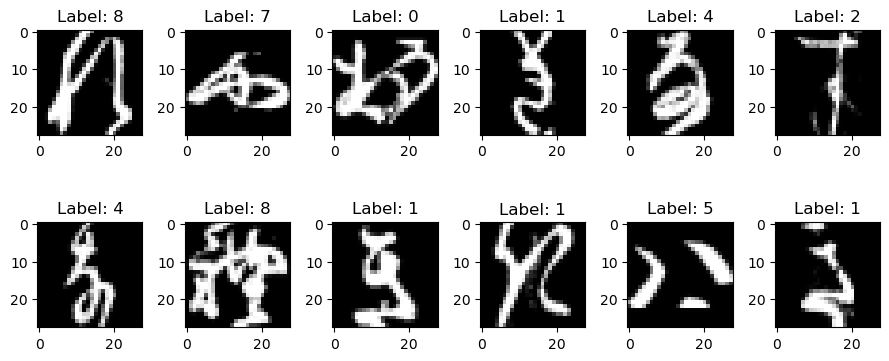

In [5]:
# Visualize first 12 samples of data
num_row = 2
num_col = 6

fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col, 2*num_row))
for i in range(num_row*num_col):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(data.data[i], cmap='gray')
    ax.set_title('Label: {}'.format(data.targets[i]))
plt.tight_layout()
plt.show()

In [6]:
data.data[0].shape 
# Each image is 28x28 with 1 channel only (greyscale), so a batch is BS X 28 X 28

torch.Size([28, 28])

In [13]:
# Use hold-out method on train dataset for train-validation splitting. Proportion is 70-30
from torch.utils.data.sampler import SubsetRandomSampler

N = len(data)
idx = list(range(N))

train_size = int(np.floor(N * 0.7))

shuffle_dataset = True
if shuffle_dataset:
    np.random.seed(42)
    np.random.shuffle(idx)

train_idx, val_idx = idx[:train_size], idx[train_size:]

train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

train_loader = torch.utils.data.DataLoader(data, batch_size = BS, sampler=train_idx)
val_loader = torch.utils.data.DataLoader(data, batch_size = BS, sampler=val_idx)


# Modelling

## CNNs

In [132]:
class CNN(nn.Module):
    def __init__(self, regularize=False, regularize_param = 0.2, fine_tuning = False):
        super().__init__()

        # Convolution Layer 1: BS x 28 x 28 -> BS X 28 x 28 x 3
        self.conv_layer_1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3, stride=1, padding=0, dilation=1, groups=1)

        # Pooling: BS X 26 x 26 x 3 -> BS x 13 x 13 x 3
        self.pool_1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Layer 1: BS x 13 x 13 x 3 -> BS x 255
        self.hidden_1 = nn.Linear(13*13*3, 255)

        # Layer 2: BS x 255 -> 10
        self.hidden_2 = nn.Linear(255, 10)

        self.regularize = regularize # boolean value
        if self.regularize:
            self.dropout = torch.nn.Dropout(p=regularize_param)
            self.fine_tuning = fine_tuning


    def forward(self, x):
        x = self.conv_layer_1(x)
        x = self.pool_1(x)
        x = F.relu(x)
        x = x.flatten(start_dim=1)

        if self.regularize and not self.fine_tuning:
            x = self.dropout(x)
            

        x = self.hidden_1(x)
        x = F.relu(x)

        if self.regularize and self.fine_tuning:
            x = self.dropout(x)

        x = self.hidden_2(x)
        x = F.relu(x)

        return x 

## FCNNs

In [160]:
class FCNN(nn.Module):
    def __init__(self, regularize=False, regularize_param = 0.2, fine_tuning = False):
        super().__init__()

        self.layer_1 = nn.Linear(28*28, 1024)
        self.layer_2 = nn.Linear(1024, 2048)
        self.layer_3 = nn.Linear(2048, 512)
        self.out = nn.Linear(512, 10)

        self.regularize = regularize # boolean value
        if self.regularize:
            self.dropout = torch.nn.Dropout(p=regularize_param)
            self.fine_tuning = fine_tuning


    def forward(self, x):
        x = x.flatten(start_dim=1)
        
        if self.regularize and not self.fine_tuning:
            x = self.dropout(x)


        x = self.layer_1(x)
        x = F.relu(x)
        x = self.layer_2(x)
        x = F.tanh(x)

        if self.regularize and self.fine_tuning:
            x = self.dropout(x)


        x = self.layer_3(x)
        x = F.relu(x)
        x = self.out(x)

        return x

## Define Auxiliary Functions (define the training logic, testing logic, and get confusion matrix)

In [41]:
# functions

def get_accuracy(logit, target):
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects / target.size(0)
    return accuracy.item()


def compute_weight_norm(model):
    norm = 0.0
    for name, param in model.named_parameters():
      if "weight" in name:
        norm += torch.norm(param.data, p= 2)
    return norm.cpu().item()


def train_model(model, num_epochs, trainloader, criterion, optimizer):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model = model.to(device)

    losses = []
    print("TRAINING MODEL!")

    for epoch in (range(num_epochs)):
        train_running_loss = 0.0
        train_acc = 0.0

        # Set the model to training mode
        model = model.train()
        start = time()
        ## training step
        for i, (images, labels) in tqdm(enumerate(trainloader)):
            
            images = images.to(device)
            labels = labels.to(device)

            ## forward + backprop + loss
            logits = model(images)
            loss = criterion(logits, labels)

            # Reset the gradients to zero
            optimizer.zero_grad()

            loss.backward()

            ## update model params
            optimizer.step()

            train_running_loss += loss.item()
            train_acc += get_accuracy(logits, labels)
        
            
        losses.append(train_running_loss / i)
        model.eval()

        print(f"Epoch: {epoch+1} | Loss: {train_running_loss / i:.4f} | Train Accuracy: {train_acc/i:.4f} | Time: {time()-start:.2f}") 
    
    return losses

In [255]:
def test_model(model, valloader, criterion):
    # get losses on test dataset

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model = model.to(device)

    running_loss = 0
    print("EVALUATING MODEL LOSS!")
    model = model.eval()

    start = time()
    ## training step
    for i, (images, labels) in tqdm(enumerate(valloader)):
        
        images = images.to(device)
        labels = labels.to(device)

        ## fp -> loss
        logits = model(images)
        loss = criterion(logits, labels)

        # Reset the gradients to zero
        ## update model params

        running_loss += loss.item()
        
            

    print(f"Average Loss: {running_loss/i} | Time: {time()-start:.2f}") 
    
    return running_loss/i

In [256]:
import sklearn.metrics 

def val_model(model, valloader, data):
    # Obs. data parameter is just to get the number of classes

    model.eval() # Sets to evaluation mode: i'm basically just freezing the gradients

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Initialize empty confusion matrix
    CLASSES = data.targets.unique()

    CLASSES = CLASSES.to(device)
    
    N_CLASSES = CLASSES.shape[0]

    my_confusion_matrix = torch.zeros((N_CLASSES, N_CLASSES))

    print("EVALUATING MODEL")
    for images, labels in tqdm(valloader):
        images = images.to(device)
        labels = labels.to(device)
        
        y_hat = model(images)
        y_pred = torch.argmax(y_hat, dim=1)

        # Copy to CPU memory since i'm going to use sklearn (idk)
        labels_ = labels.cpu()
        y_pred_ = y_pred.cpu()
        CLASSES_= CLASSES.cpu()

        cm_i = sklearn.metrics.confusion_matrix(labels_, y_pred_, labels=CLASSES_)

        my_confusion_matrix += cm_i
    
    return my_confusion_matrix

# Model Training

In [28]:
CE = nn.CrossEntropyLoss()


In [ ]:
my_cnn = CNN()

cnn_optimizer1 = torch.optim.Adam(my_cnn.parameters())

cnn_loss1 = train_model(my_cnn, 50, train_loader, CE, cnn_optimizer1)

TRAINING MODEL!


329it [00:06, 54.72it/s]


Epoch: 1 | Loss: 0.7427 | Train Accuracy: 79.2635 | Time: 6.02


329it [00:05, 55.14it/s]


Epoch: 2 | Loss: 0.3752 | Train Accuracy: 88.5790 | Time: 5.97


329it [00:05, 56.03it/s]


Epoch: 3 | Loss: 0.2779 | Train Accuracy: 91.4825 | Time: 5.88


329it [00:06, 54.16it/s]


Epoch: 4 | Loss: 0.2235 | Train Accuracy: 93.1498 | Time: 6.08


329it [00:06, 50.21it/s]


Epoch: 5 | Loss: 0.1307 | Train Accuracy: 96.6297 | Time: 6.56


329it [00:07, 44.89it/s]


Epoch: 6 | Loss: 0.0991 | Train Accuracy: 97.5395 | Time: 7.34


329it [00:11, 28.26it/s]


Epoch: 7 | Loss: 0.0785 | Train Accuracy: 98.1779 | Time: 11.65


329it [00:06, 54.51it/s]


Epoch: 8 | Loss: 0.0632 | Train Accuracy: 98.6876 | Time: 6.05


329it [00:06, 54.70it/s]


Epoch: 9 | Loss: 0.0510 | Train Accuracy: 99.0735 | Time: 6.02


329it [00:06, 54.70it/s]


Epoch: 10 | Loss: 0.0417 | Train Accuracy: 99.3093 | Time: 6.02


329it [00:05, 55.04it/s]


Epoch: 11 | Loss: 0.0336 | Train Accuracy: 99.5546 | Time: 5.98


329it [00:05, 55.17it/s]


Epoch: 12 | Loss: 0.0261 | Train Accuracy: 99.7547 | Time: 5.97


329it [00:05, 56.47it/s]


Epoch: 13 | Loss: 0.0216 | Train Accuracy: 99.8547 | Time: 5.83


329it [00:05, 56.65it/s]


Epoch: 14 | Loss: 0.0189 | Train Accuracy: 99.8952 | Time: 5.81


329it [00:05, 58.26it/s]


Epoch: 15 | Loss: 0.0164 | Train Accuracy: 99.9405 | Time: 5.65


329it [00:05, 56.03it/s]


Epoch: 16 | Loss: 0.0175 | Train Accuracy: 99.8333 | Time: 5.88


329it [00:05, 55.84it/s]


Epoch: 17 | Loss: 0.0161 | Train Accuracy: 99.8619 | Time: 5.89


329it [00:05, 56.58it/s]


Epoch: 18 | Loss: 0.0132 | Train Accuracy: 99.9809 | Time: 5.82


329it [00:05, 55.38it/s]


Epoch: 19 | Loss: 0.0101 | Train Accuracy: 100.0524 | Time: 5.94


329it [00:05, 56.77it/s]


Epoch: 20 | Loss: 0.0109 | Train Accuracy: 99.9905 | Time: 5.80


329it [00:05, 55.78it/s]


Epoch: 21 | Loss: 0.0093 | Train Accuracy: 100.0524 | Time: 5.90


329it [00:05, 56.09it/s]


Epoch: 22 | Loss: 0.0074 | Train Accuracy: 100.1072 | Time: 5.87


329it [00:05, 56.48it/s]


Epoch: 23 | Loss: 0.0070 | Train Accuracy: 100.1072 | Time: 5.83


329it [00:05, 55.89it/s]


Epoch: 24 | Loss: 0.0100 | Train Accuracy: 100.0119 | Time: 5.89


329it [00:05, 55.06it/s]


Epoch: 25 | Loss: 0.0065 | Train Accuracy: 100.1215 | Time: 5.98


329it [00:05, 56.26it/s]


Epoch: 26 | Loss: 0.0050 | Train Accuracy: 100.1643 | Time: 5.85


329it [00:05, 58.82it/s]


Epoch: 27 | Loss: 0.0059 | Train Accuracy: 100.1286 | Time: 5.60


329it [00:05, 58.11it/s]


Epoch: 28 | Loss: 0.0166 | Train Accuracy: 99.7475 | Time: 5.67


329it [00:05, 57.07it/s]


Epoch: 29 | Loss: 0.0075 | Train Accuracy: 100.0667 | Time: 5.77


329it [00:05, 57.21it/s]


Epoch: 30 | Loss: 0.0041 | Train Accuracy: 100.1739 | Time: 5.76


329it [00:05, 57.79it/s]


Epoch: 31 | Loss: 0.0029 | Train Accuracy: 100.2167 | Time: 5.69


329it [00:05, 56.90it/s]


Epoch: 32 | Loss: 0.0025 | Train Accuracy: 100.2215 | Time: 5.79


329it [00:05, 56.76it/s]


Epoch: 33 | Loss: 0.0029 | Train Accuracy: 100.2096 | Time: 5.80


329it [00:05, 56.58it/s]


Epoch: 34 | Loss: 0.0164 | Train Accuracy: 99.7404 | Time: 5.82


329it [00:05, 56.39it/s]


Epoch: 35 | Loss: 0.0087 | Train Accuracy: 100.0238 | Time: 5.84


329it [00:05, 58.32it/s]


Epoch: 36 | Loss: 0.0036 | Train Accuracy: 100.2025 | Time: 5.64


329it [00:05, 57.13it/s]


Epoch: 37 | Loss: 0.0025 | Train Accuracy: 100.2215 | Time: 5.76


329it [00:05, 57.80it/s]


Epoch: 38 | Loss: 0.0023 | Train Accuracy: 100.2239 | Time: 5.70


329it [00:05, 57.59it/s]


Epoch: 39 | Loss: 0.0023 | Train Accuracy: 100.2215 | Time: 5.72


329it [00:05, 55.87it/s]


Epoch: 40 | Loss: 0.0023 | Train Accuracy: 100.2239 | Time: 5.89


329it [00:05, 56.56it/s]


Epoch: 41 | Loss: 0.0022 | Train Accuracy: 100.2239 | Time: 5.82


329it [00:05, 55.15it/s]


Epoch: 42 | Loss: 0.0022 | Train Accuracy: 100.2215 | Time: 5.97


329it [00:05, 55.39it/s]


Epoch: 43 | Loss: 0.0022 | Train Accuracy: 100.2239 | Time: 5.94


329it [00:05, 56.54it/s]


Epoch: 44 | Loss: 0.0022 | Train Accuracy: 100.2239 | Time: 5.82


329it [00:05, 55.87it/s]


Epoch: 45 | Loss: 0.0022 | Train Accuracy: 100.2239 | Time: 5.89


329it [00:05, 55.22it/s]


Epoch: 46 | Loss: 0.0022 | Train Accuracy: 100.2215 | Time: 5.96


329it [00:06, 54.57it/s]


Epoch: 47 | Loss: 0.0179 | Train Accuracy: 99.8118 | Time: 6.03


329it [00:05, 56.28it/s]


Epoch: 48 | Loss: 0.0180 | Train Accuracy: 99.7642 | Time: 5.85


329it [00:05, 58.42it/s]


Epoch: 49 | Loss: 0.0045 | Train Accuracy: 100.1643 | Time: 5.64


329it [00:05, 55.38it/s]

Epoch: 50 | Loss: 0.0026 | Train Accuracy: 100.2215 | Time: 5.94


In [306]:
torch.save(my_cnn.state_dict(), "./weights/cnn_super") # SAVE THE WEIGHTS FOR PRESERVABILITY!!!!

In [307]:
my_cnn_again = CNN()

CE = nn.CrossEntropyLoss()
cnn_optimizer1 = torch.optim.Adam(my_cnn_again.parameters())

cnn_loss2 = train_model(my_cnn_again, 50, train_loader, CE, cnn_optimizer1)

TRAINING MODEL!


329it [00:06, 53.04it/s]


Epoch: 1 | Loss: 1.2270 | Train Accuracy: 57.7315 | Time: 6.21


329it [00:06, 54.46it/s]


Epoch: 2 | Loss: 1.0294 | Train Accuracy: 61.6068 | Time: 6.05


329it [00:06, 53.97it/s]


Epoch: 3 | Loss: 0.9614 | Train Accuracy: 63.0478 | Time: 6.10


329it [00:06, 53.08it/s]


Epoch: 4 | Loss: 0.9174 | Train Accuracy: 63.9196 | Time: 6.20


329it [00:05, 57.21it/s]


Epoch: 5 | Loss: 0.8889 | Train Accuracy: 64.4412 | Time: 5.76


329it [00:05, 56.81it/s]


Epoch: 6 | Loss: 0.8654 | Train Accuracy: 65.0367 | Time: 5.79


329it [00:05, 56.28it/s]


Epoch: 7 | Loss: 0.8471 | Train Accuracy: 65.4702 | Time: 5.85


329it [00:05, 55.77it/s]


Epoch: 8 | Loss: 0.8328 | Train Accuracy: 65.7631 | Time: 5.90


329it [00:05, 56.20it/s]


Epoch: 9 | Loss: 0.8219 | Train Accuracy: 65.9537 | Time: 5.86


329it [00:05, 57.26it/s]


Epoch: 10 | Loss: 0.8132 | Train Accuracy: 66.1752 | Time: 5.75


329it [00:05, 58.53it/s]


Epoch: 11 | Loss: 0.7587 | Train Accuracy: 68.6309 | Time: 5.62


329it [00:05, 58.34it/s]


Epoch: 12 | Loss: 0.5723 | Train Accuracy: 77.9321 | Time: 5.64


329it [00:05, 57.51it/s]


Epoch: 13 | Loss: 0.5355 | Train Accuracy: 78.6966 | Time: 5.73


329it [00:05, 57.21it/s]


Epoch: 14 | Loss: 0.5228 | Train Accuracy: 78.9110 | Time: 5.75


329it [00:05, 56.90it/s]


Epoch: 15 | Loss: 0.5108 | Train Accuracy: 79.1921 | Time: 5.79


329it [00:05, 57.52it/s]


Epoch: 16 | Loss: 0.5013 | Train Accuracy: 79.3564 | Time: 5.72


329it [00:05, 56.67it/s]


Epoch: 17 | Loss: 0.4944 | Train Accuracy: 79.4731 | Time: 5.81


329it [00:05, 55.81it/s]


Epoch: 18 | Loss: 0.4912 | Train Accuracy: 79.5112 | Time: 5.90


329it [00:05, 57.40it/s]


Epoch: 19 | Loss: 0.4893 | Train Accuracy: 79.4922 | Time: 5.74


329it [00:05, 56.83it/s]


Epoch: 20 | Loss: 0.4901 | Train Accuracy: 79.4612 | Time: 5.79


329it [00:05, 58.07it/s]


Epoch: 21 | Loss: 0.4856 | Train Accuracy: 79.5636 | Time: 5.67


329it [00:05, 57.02it/s]


Epoch: 22 | Loss: 0.4852 | Train Accuracy: 79.5494 | Time: 5.77


329it [00:05, 57.06it/s]


Epoch: 23 | Loss: 0.4848 | Train Accuracy: 79.5470 | Time: 5.77


329it [00:05, 56.34it/s]


Epoch: 24 | Loss: 0.4841 | Train Accuracy: 79.5613 | Time: 5.84


329it [00:05, 55.69it/s]


Epoch: 25 | Loss: 0.4828 | Train Accuracy: 79.5827 | Time: 5.91


329it [00:05, 56.04it/s]


Epoch: 26 | Loss: 0.4831 | Train Accuracy: 79.5946 | Time: 5.87


329it [00:05, 55.36it/s]


Epoch: 27 | Loss: 0.4837 | Train Accuracy: 79.5636 | Time: 5.95


329it [00:05, 56.17it/s]


Epoch: 28 | Loss: 0.4807 | Train Accuracy: 79.6351 | Time: 5.86


329it [00:05, 56.29it/s]


Epoch: 29 | Loss: 0.4811 | Train Accuracy: 79.6375 | Time: 5.85


329it [00:05, 58.23it/s]


Epoch: 30 | Loss: 0.4783 | Train Accuracy: 79.6732 | Time: 5.65


329it [00:05, 56.88it/s]


Epoch: 31 | Loss: 0.4800 | Train Accuracy: 79.6351 | Time: 5.79


329it [00:05, 56.28it/s]


Epoch: 32 | Loss: 0.4810 | Train Accuracy: 79.6232 | Time: 5.85


329it [00:05, 56.63it/s]


Epoch: 33 | Loss: 0.4802 | Train Accuracy: 79.6232 | Time: 5.81


329it [00:05, 57.70it/s]


Epoch: 34 | Loss: 0.4780 | Train Accuracy: 79.6732 | Time: 5.71


329it [00:05, 57.00it/s]


Epoch: 35 | Loss: 0.4794 | Train Accuracy: 79.6470 | Time: 5.77


329it [00:05, 56.20it/s]


Epoch: 36 | Loss: 0.4769 | Train Accuracy: 79.7208 | Time: 5.86


329it [00:05, 56.62it/s]


Epoch: 37 | Loss: 0.4763 | Train Accuracy: 79.7280 | Time: 5.81


329it [00:05, 57.31it/s]


Epoch: 38 | Loss: 0.4751 | Train Accuracy: 79.7447 | Time: 5.74


329it [00:05, 56.19it/s]


Epoch: 39 | Loss: 0.4746 | Train Accuracy: 79.7566 | Time: 5.86


329it [00:05, 56.60it/s]


Epoch: 40 | Loss: 0.4769 | Train Accuracy: 79.7161 | Time: 5.81


329it [00:05, 55.12it/s]


Epoch: 41 | Loss: 0.4821 | Train Accuracy: 79.5827 | Time: 5.97


329it [00:06, 53.25it/s]


Epoch: 42 | Loss: 0.4806 | Train Accuracy: 79.6327 | Time: 6.18


329it [00:06, 53.04it/s]


Epoch: 43 | Loss: 0.4765 | Train Accuracy: 79.7018 | Time: 6.21


329it [00:06, 53.68it/s]


Epoch: 44 | Loss: 0.4746 | Train Accuracy: 79.7566 | Time: 6.13


329it [00:06, 54.21it/s]


Epoch: 45 | Loss: 0.4754 | Train Accuracy: 79.7328 | Time: 6.07


329it [00:05, 55.00it/s]


Epoch: 46 | Loss: 0.4751 | Train Accuracy: 79.7542 | Time: 5.98


329it [00:05, 56.43it/s]


Epoch: 47 | Loss: 0.4740 | Train Accuracy: 79.7756 | Time: 5.83


329it [00:05, 55.71it/s]


Epoch: 48 | Loss: 0.4791 | Train Accuracy: 79.6494 | Time: 5.91


329it [00:06, 53.81it/s]


Epoch: 49 | Loss: 0.4793 | Train Accuracy: 79.6565 | Time: 6.12


329it [00:06, 54.64it/s]


Epoch: 50 | Loss: 0.4760 | Train Accuracy: 79.7351 | Time: 6.02


In [308]:
torch.save(my_cnn_again.state_dict(), "./weights/cnn_bad_minima") # SAVE THE WEIGHTS FOR PRESERVABILITY!!!!

In [321]:
np.savetxt('./losses/cnn2.csv', cnn_loss2, delimiter=',', fmt='%.16f')
np.savetxt('./losses/cnn1.csv', cnn_loss1, delimiter=',', fmt='%.16f')


In [25]:
# Notice how the results have drastically changed, meaning that the problem is likely non-convex and the initialization may be a crucial step.
cnn_normal = CNN()
cnn_zeros = CNN()
cnn_dirac = CNN()
cnn_xavier = CNN()

torch.nn.init.normal_(cnn_normal.conv_layer_1.weight)
torch.nn.init.zeros_(cnn_zeros.conv_layer_1.weight)
torch.nn.init.dirac_(cnn_dirac.conv_layer_1.weight)
torch.nn.init.xavier_uniform_(cnn_xavier.conv_layer_1.weight)


Parameter containing:
tensor([[[[-0.1029,  0.3977, -0.1630],
          [-0.0562, -0.0006,  0.3300],
          [ 0.3204, -0.0441,  0.1337]]],


        [[[-0.1120,  0.2290, -0.2509],
          [ 0.2910,  0.3678, -0.3336],
          [ 0.3423, -0.3483,  0.0992]]],


        [[[ 0.2075,  0.1258,  0.4081],
          [-0.2243, -0.2957, -0.2658],
          [-0.1528,  0.2483,  0.1135]]]], requires_grad=True)

In [29]:
models = [cnn_normal, cnn_zeros, cnn_dirac, cnn_xavier]

renamer = {
    cnn_normal: 'cnn normal',
    cnn_zeros: 'cnn zeros',
    cnn_dirac: 'cnn dirac',
    cnn_xavier: 'xavier'
}

losses = {}

In [30]:
for model in models:  
    print(renamer[model])
    losses[renamer[model]] = train_model(model, 50, train_loader, CE, torch.optim.Adam(model.parameters()))

    print("="*80)
    print()
    pass


cnn normal
TRAINING MODEL!


329it [00:05, 60.37it/s]


Epoch: 1 | Loss: 1.1901 | Train Accuracy: 64.8414 | Time: 5.46


329it [00:05, 60.90it/s]


Epoch: 2 | Loss: 0.8740 | Train Accuracy: 73.2755 | Time: 5.41


329it [00:05, 56.69it/s]


Epoch: 3 | Loss: 0.6424 | Train Accuracy: 75.8313 | Time: 5.81


329it [00:05, 56.07it/s]


Epoch: 4 | Loss: 0.5985 | Train Accuracy: 76.9555 | Time: 5.87


329it [00:05, 56.74it/s]


Epoch: 5 | Loss: 0.5707 | Train Accuracy: 77.6510 | Time: 5.80


329it [00:05, 56.39it/s]


Epoch: 6 | Loss: 0.5503 | Train Accuracy: 78.1893 | Time: 5.84


329it [00:05, 55.10it/s]


Epoch: 7 | Loss: 0.5357 | Train Accuracy: 78.4751 | Time: 5.98


329it [00:05, 56.42it/s]


Epoch: 8 | Loss: 0.5232 | Train Accuracy: 78.7586 | Time: 5.83


329it [00:05, 57.38it/s]


Epoch: 9 | Loss: 0.5137 | Train Accuracy: 78.9563 | Time: 5.74


329it [00:05, 56.14it/s]


Epoch: 10 | Loss: 0.5077 | Train Accuracy: 79.0611 | Time: 5.86


329it [00:05, 56.53it/s]


Epoch: 11 | Loss: 0.5025 | Train Accuracy: 79.1683 | Time: 5.82


329it [00:05, 55.23it/s]


Epoch: 12 | Loss: 0.4983 | Train Accuracy: 79.1945 | Time: 5.96


329it [00:05, 56.30it/s]


Epoch: 13 | Loss: 0.4953 | Train Accuracy: 79.2373 | Time: 5.85


329it [00:05, 57.71it/s]


Epoch: 14 | Loss: 0.4944 | Train Accuracy: 79.2540 | Time: 5.70


329it [00:05, 55.64it/s]


Epoch: 15 | Loss: 0.4928 | Train Accuracy: 79.2540 | Time: 5.92


329it [00:05, 58.08it/s]


Epoch: 16 | Loss: 0.4903 | Train Accuracy: 79.3421 | Time: 5.67


329it [00:06, 50.55it/s]


Epoch: 17 | Loss: 0.4885 | Train Accuracy: 79.3779 | Time: 6.51


329it [00:06, 52.99it/s]


Epoch: 18 | Loss: 0.4845 | Train Accuracy: 79.4303 | Time: 6.21


329it [00:05, 55.16it/s]


Epoch: 19 | Loss: 0.4826 | Train Accuracy: 79.4755 | Time: 5.97


329it [00:05, 55.48it/s]


Epoch: 20 | Loss: 0.4821 | Train Accuracy: 79.4946 | Time: 5.93


329it [00:05, 57.64it/s]


Epoch: 21 | Loss: 0.4853 | Train Accuracy: 79.4112 | Time: 5.71


329it [00:05, 57.08it/s]


Epoch: 22 | Loss: 0.4905 | Train Accuracy: 79.2754 | Time: 5.77


329it [00:04, 67.71it/s]


Epoch: 23 | Loss: 0.4826 | Train Accuracy: 79.4827 | Time: 4.86


329it [00:05, 57.76it/s]


Epoch: 24 | Loss: 0.4805 | Train Accuracy: 79.5136 | Time: 5.70


329it [00:05, 55.48it/s]


Epoch: 25 | Loss: 0.4829 | Train Accuracy: 79.4469 | Time: 5.93


329it [00:06, 53.21it/s]


Epoch: 26 | Loss: 0.4846 | Train Accuracy: 79.4398 | Time: 6.19


329it [00:06, 49.30it/s]


Epoch: 27 | Loss: 0.4827 | Train Accuracy: 79.4922 | Time: 6.68


329it [00:06, 54.80it/s]


Epoch: 28 | Loss: 0.4808 | Train Accuracy: 79.5279 | Time: 6.01


329it [00:05, 57.00it/s]


Epoch: 29 | Loss: 0.4802 | Train Accuracy: 79.5470 | Time: 5.78


329it [00:05, 57.57it/s]


Epoch: 30 | Loss: 0.4791 | Train Accuracy: 79.5875 | Time: 5.72


329it [00:05, 58.89it/s]


Epoch: 31 | Loss: 0.4839 | Train Accuracy: 79.5065 | Time: 5.59


329it [00:06, 54.20it/s]


Epoch: 32 | Loss: 0.4781 | Train Accuracy: 79.6399 | Time: 6.07


329it [00:06, 54.64it/s]


Epoch: 33 | Loss: 0.4769 | Train Accuracy: 79.6565 | Time: 6.03


329it [00:05, 56.04it/s]


Epoch: 34 | Loss: 0.4777 | Train Accuracy: 79.6422 | Time: 5.87


329it [00:05, 54.93it/s]


Epoch: 35 | Loss: 0.4821 | Train Accuracy: 79.5017 | Time: 5.99


329it [00:06, 53.26it/s]


Epoch: 36 | Loss: 0.4786 | Train Accuracy: 79.6089 | Time: 6.18


329it [00:06, 54.34it/s]


Epoch: 37 | Loss: 0.4767 | Train Accuracy: 79.6637 | Time: 6.06


329it [00:06, 53.40it/s]


Epoch: 38 | Loss: 0.4763 | Train Accuracy: 79.6708 | Time: 6.17


329it [00:06, 54.52it/s]


Epoch: 39 | Loss: 0.4791 | Train Accuracy: 79.6065 | Time: 6.04


329it [00:05, 54.96it/s]


Epoch: 40 | Loss: 0.4781 | Train Accuracy: 79.6375 | Time: 5.99


329it [00:05, 55.72it/s]


Epoch: 41 | Loss: 0.4761 | Train Accuracy: 79.6708 | Time: 5.91


329it [00:05, 55.69it/s]


Epoch: 42 | Loss: 0.4759 | Train Accuracy: 79.6780 | Time: 5.91


329it [00:05, 55.42it/s]


Epoch: 43 | Loss: 0.4754 | Train Accuracy: 79.6875 | Time: 5.94


329it [00:05, 54.99it/s]


Epoch: 44 | Loss: 0.4752 | Train Accuracy: 79.6875 | Time: 5.99


329it [00:06, 53.58it/s]


Epoch: 45 | Loss: 0.4752 | Train Accuracy: 79.6875 | Time: 6.14


329it [00:06, 53.34it/s]


Epoch: 46 | Loss: 0.4752 | Train Accuracy: 79.6875 | Time: 6.17


329it [00:05, 56.55it/s]


Epoch: 47 | Loss: 0.4752 | Train Accuracy: 79.6875 | Time: 5.82


329it [00:05, 57.58it/s]


Epoch: 48 | Loss: 0.4926 | Train Accuracy: 79.2754 | Time: 5.72


329it [00:05, 56.60it/s]


Epoch: 49 | Loss: 0.4783 | Train Accuracy: 79.6280 | Time: 5.82


329it [00:06, 52.69it/s]


Epoch: 50 | Loss: 0.4758 | Train Accuracy: 79.6875 | Time: 6.25

cnn zeros
TRAINING MODEL!


329it [00:05, 55.60it/s]


Epoch: 1 | Loss: 1.6883 | Train Accuracy: 43.4499 | Time: 5.92


329it [00:06, 53.90it/s]


Epoch: 2 | Loss: 1.2698 | Train Accuracy: 56.7240 | Time: 6.11


329it [00:05, 54.93it/s]


Epoch: 3 | Loss: 1.1275 | Train Accuracy: 60.7470 | Time: 5.99


329it [00:06, 52.15it/s]


Epoch: 4 | Loss: 1.0575 | Train Accuracy: 62.1713 | Time: 6.31


329it [00:05, 56.21it/s]


Epoch: 5 | Loss: 1.0091 | Train Accuracy: 63.2860 | Time: 5.86


329it [00:05, 55.63it/s]


Epoch: 6 | Loss: 0.9715 | Train Accuracy: 64.1649 | Time: 5.92


329it [00:06, 53.21it/s]


Epoch: 7 | Loss: 0.9411 | Train Accuracy: 64.8985 | Time: 6.19


329it [00:05, 56.40it/s]


Epoch: 8 | Loss: 0.9160 | Train Accuracy: 65.4392 | Time: 5.84


329it [00:05, 56.77it/s]


Epoch: 9 | Loss: 0.8951 | Train Accuracy: 66.0299 | Time: 5.80


329it [00:05, 57.20it/s]


Epoch: 10 | Loss: 0.8787 | Train Accuracy: 66.3753 | Time: 5.76


329it [00:05, 55.88it/s]


Epoch: 11 | Loss: 0.8649 | Train Accuracy: 66.6444 | Time: 5.89


329it [00:05, 55.01it/s]


Epoch: 12 | Loss: 0.8525 | Train Accuracy: 66.8659 | Time: 5.98


329it [00:05, 56.26it/s]


Epoch: 13 | Loss: 0.8411 | Train Accuracy: 67.1684 | Time: 5.85


329it [00:05, 56.13it/s]


Epoch: 14 | Loss: 0.8309 | Train Accuracy: 67.4567 | Time: 5.86


329it [00:05, 56.48it/s]


Epoch: 15 | Loss: 0.8208 | Train Accuracy: 67.7329 | Time: 5.83


329it [00:05, 56.11it/s]


Epoch: 16 | Loss: 0.8117 | Train Accuracy: 67.9330 | Time: 5.87


329it [00:05, 56.16it/s]


Epoch: 17 | Loss: 0.8039 | Train Accuracy: 68.0497 | Time: 5.87


329it [00:06, 54.36it/s]


Epoch: 18 | Loss: 0.7971 | Train Accuracy: 68.1974 | Time: 6.06


329it [00:05, 56.25it/s]


Epoch: 19 | Loss: 0.7909 | Train Accuracy: 68.3189 | Time: 5.85


329it [00:06, 54.53it/s]


Epoch: 20 | Loss: 0.7848 | Train Accuracy: 68.4094 | Time: 6.04


329it [00:06, 54.75it/s]


Epoch: 21 | Loss: 0.7793 | Train Accuracy: 68.5380 | Time: 6.01


329it [00:05, 55.82it/s]


Epoch: 22 | Loss: 0.7745 | Train Accuracy: 68.6119 | Time: 5.90


329it [00:05, 55.85it/s]


Epoch: 23 | Loss: 0.7698 | Train Accuracy: 68.6928 | Time: 5.89


329it [00:05, 56.52it/s]


Epoch: 24 | Loss: 0.7660 | Train Accuracy: 68.7595 | Time: 5.82


329it [00:05, 56.99it/s]


Epoch: 25 | Loss: 0.7621 | Train Accuracy: 68.8381 | Time: 5.78


329it [00:05, 57.30it/s]


Epoch: 26 | Loss: 0.7591 | Train Accuracy: 68.8572 | Time: 5.75


329it [00:05, 58.27it/s]


Epoch: 27 | Loss: 0.7552 | Train Accuracy: 68.9286 | Time: 5.65


329it [00:05, 56.08it/s]


Epoch: 28 | Loss: 0.7524 | Train Accuracy: 69.0168 | Time: 5.87


329it [00:05, 56.45it/s]


Epoch: 29 | Loss: 0.7490 | Train Accuracy: 69.0525 | Time: 5.83


329it [00:05, 56.52it/s]


Epoch: 30 | Loss: 0.7466 | Train Accuracy: 69.0906 | Time: 5.82


329it [00:05, 56.93it/s]


Epoch: 31 | Loss: 0.7437 | Train Accuracy: 69.1049 | Time: 5.78


329it [00:05, 56.09it/s]


Epoch: 32 | Loss: 0.7423 | Train Accuracy: 69.1525 | Time: 5.87


329it [00:05, 56.27it/s]


Epoch: 33 | Loss: 0.7400 | Train Accuracy: 69.1859 | Time: 5.85


329it [00:05, 56.96it/s]


Epoch: 34 | Loss: 0.7387 | Train Accuracy: 69.2073 | Time: 5.78


329it [00:05, 54.92it/s]


Epoch: 35 | Loss: 0.7367 | Train Accuracy: 69.2550 | Time: 5.99


329it [00:05, 56.94it/s]


Epoch: 36 | Loss: 0.7345 | Train Accuracy: 69.2812 | Time: 5.78


329it [00:05, 56.37it/s]


Epoch: 37 | Loss: 0.7335 | Train Accuracy: 69.3097 | Time: 5.84


329it [00:05, 57.12it/s]


Epoch: 38 | Loss: 0.7315 | Train Accuracy: 69.3455 | Time: 5.76


329it [00:05, 56.76it/s]


Epoch: 39 | Loss: 0.7301 | Train Accuracy: 69.3836 | Time: 5.80


329it [00:05, 56.40it/s]


Epoch: 40 | Loss: 0.7280 | Train Accuracy: 69.4717 | Time: 5.84


329it [00:05, 57.46it/s]


Epoch: 41 | Loss: 0.7270 | Train Accuracy: 69.4431 | Time: 5.73


329it [00:05, 55.56it/s]


Epoch: 42 | Loss: 0.7250 | Train Accuracy: 69.5289 | Time: 5.92


329it [00:06, 54.62it/s]


Epoch: 43 | Loss: 0.7245 | Train Accuracy: 69.5241 | Time: 6.03


329it [00:06, 54.80it/s]


Epoch: 44 | Loss: 0.7225 | Train Accuracy: 69.5575 | Time: 6.01


329it [00:05, 55.80it/s]


Epoch: 45 | Loss: 0.7227 | Train Accuracy: 69.5479 | Time: 5.90


329it [00:05, 55.56it/s]


Epoch: 46 | Loss: 0.7231 | Train Accuracy: 69.5193 | Time: 5.92


329it [00:05, 55.82it/s]


Epoch: 47 | Loss: 0.7205 | Train Accuracy: 69.5551 | Time: 5.90


329it [00:05, 54.86it/s]


Epoch: 48 | Loss: 0.7199 | Train Accuracy: 69.5884 | Time: 6.00


329it [00:05, 56.52it/s]


Epoch: 49 | Loss: 0.7196 | Train Accuracy: 69.5503 | Time: 5.82


329it [00:05, 55.21it/s]


Epoch: 50 | Loss: 0.7206 | Train Accuracy: 69.5265 | Time: 5.96

cnn dirac
TRAINING MODEL!


329it [00:05, 55.21it/s]


Epoch: 1 | Loss: 1.7711 | Train Accuracy: 38.8076 | Time: 5.96


329it [00:05, 55.42it/s]


Epoch: 2 | Loss: 1.6339 | Train Accuracy: 42.9187 | Time: 5.94


329it [00:05, 56.56it/s]


Epoch: 3 | Loss: 1.5505 | Train Accuracy: 44.1644 | Time: 5.82


329it [00:05, 56.16it/s]


Epoch: 4 | Loss: 1.2872 | Train Accuracy: 48.3613 | Time: 5.86


329it [00:05, 57.97it/s]


Epoch: 5 | Loss: 1.1199 | Train Accuracy: 54.8685 | Time: 5.68


329it [00:05, 57.10it/s]


Epoch: 6 | Loss: 1.0953 | Train Accuracy: 55.2544 | Time: 5.77


329it [00:05, 56.02it/s]


Epoch: 7 | Loss: 1.0796 | Train Accuracy: 55.5045 | Time: 5.88


329it [00:05, 56.16it/s]


Epoch: 8 | Loss: 1.0673 | Train Accuracy: 55.6664 | Time: 5.86


329it [00:05, 56.25it/s]


Epoch: 9 | Loss: 1.0565 | Train Accuracy: 55.8498 | Time: 5.85


329it [00:05, 58.20it/s]


Epoch: 10 | Loss: 1.0496 | Train Accuracy: 55.9928 | Time: 5.66


329it [00:07, 46.61it/s]


Epoch: 11 | Loss: 1.0427 | Train Accuracy: 56.0595 | Time: 7.06


329it [00:05, 55.00it/s]


Epoch: 12 | Loss: 1.0386 | Train Accuracy: 56.0999 | Time: 5.99


329it [00:05, 55.03it/s]


Epoch: 13 | Loss: 1.0352 | Train Accuracy: 56.1214 | Time: 5.98


329it [00:05, 56.16it/s]


Epoch: 14 | Loss: 1.0336 | Train Accuracy: 56.1714 | Time: 5.86


329it [00:06, 54.58it/s]


Epoch: 15 | Loss: 1.0298 | Train Accuracy: 56.2500 | Time: 6.03


329it [00:06, 53.68it/s]


Epoch: 16 | Loss: 1.0290 | Train Accuracy: 56.2619 | Time: 6.13


329it [00:06, 53.32it/s]


Epoch: 17 | Loss: 1.0251 | Train Accuracy: 56.3167 | Time: 6.17


329it [00:05, 54.94it/s]


Epoch: 18 | Loss: 1.0243 | Train Accuracy: 56.3095 | Time: 5.99


329it [00:05, 55.73it/s]


Epoch: 19 | Loss: 1.0210 | Train Accuracy: 56.3619 | Time: 5.91


329it [00:05, 55.92it/s]


Epoch: 20 | Loss: 1.0203 | Train Accuracy: 56.3834 | Time: 5.89


329it [00:05, 55.70it/s]


Epoch: 21 | Loss: 1.0187 | Train Accuracy: 56.4024 | Time: 5.91


329it [00:05, 55.87it/s]


Epoch: 22 | Loss: 1.0168 | Train Accuracy: 56.4477 | Time: 5.89


329it [00:06, 54.40it/s]


Epoch: 23 | Loss: 1.0184 | Train Accuracy: 56.3953 | Time: 6.05


329it [00:05, 55.91it/s]


Epoch: 24 | Loss: 1.0148 | Train Accuracy: 56.4810 | Time: 5.89


329it [00:06, 54.75it/s]


Epoch: 25 | Loss: 1.0137 | Train Accuracy: 56.4977 | Time: 6.01


329it [00:05, 56.89it/s]


Epoch: 26 | Loss: 1.0126 | Train Accuracy: 56.5192 | Time: 5.78


329it [00:05, 56.89it/s]


Epoch: 27 | Loss: 1.0114 | Train Accuracy: 56.5477 | Time: 5.79


329it [00:05, 56.88it/s]


Epoch: 28 | Loss: 1.0117 | Train Accuracy: 56.5263 | Time: 5.79


329it [00:05, 57.80it/s]


Epoch: 29 | Loss: 1.0123 | Train Accuracy: 56.5049 | Time: 5.69


329it [00:05, 57.22it/s]


Epoch: 30 | Loss: 1.0161 | Train Accuracy: 56.4596 | Time: 5.75


329it [00:05, 57.55it/s]


Epoch: 31 | Loss: 1.0115 | Train Accuracy: 56.5358 | Time: 5.72


329it [00:05, 56.82it/s]


Epoch: 32 | Loss: 1.0124 | Train Accuracy: 56.5049 | Time: 5.79


329it [00:05, 56.83it/s]


Epoch: 33 | Loss: 1.0136 | Train Accuracy: 56.4929 | Time: 5.79


329it [00:05, 57.93it/s]


Epoch: 34 | Loss: 1.0107 | Train Accuracy: 56.5716 | Time: 5.68


329it [00:05, 56.15it/s]


Epoch: 35 | Loss: 1.0090 | Train Accuracy: 56.5930 | Time: 5.86


329it [00:05, 57.28it/s]


Epoch: 36 | Loss: 1.0091 | Train Accuracy: 56.5954 | Time: 5.75


329it [00:05, 55.48it/s]


Epoch: 37 | Loss: 1.0093 | Train Accuracy: 56.5930 | Time: 5.93


329it [00:06, 54.71it/s]


Epoch: 38 | Loss: 1.0113 | Train Accuracy: 56.5644 | Time: 6.02


329it [00:05, 57.21it/s]


Epoch: 39 | Loss: 1.0114 | Train Accuracy: 56.5501 | Time: 5.75


329it [00:05, 56.74it/s]


Epoch: 40 | Loss: 1.0098 | Train Accuracy: 56.5882 | Time: 5.80


329it [00:05, 56.72it/s]


Epoch: 41 | Loss: 1.0104 | Train Accuracy: 56.5644 | Time: 5.80


329it [00:05, 56.75it/s]


Epoch: 42 | Loss: 1.0095 | Train Accuracy: 56.5882 | Time: 5.80


329it [00:05, 56.89it/s]


Epoch: 43 | Loss: 1.0088 | Train Accuracy: 56.6049 | Time: 5.79


329it [00:05, 57.26it/s]


Epoch: 44 | Loss: 1.0088 | Train Accuracy: 56.6216 | Time: 5.75


329it [00:05, 55.77it/s]


Epoch: 45 | Loss: 1.0099 | Train Accuracy: 56.6049 | Time: 5.90


329it [00:05, 56.67it/s]


Epoch: 46 | Loss: 1.0092 | Train Accuracy: 56.6001 | Time: 5.81


329it [00:05, 56.35it/s]


Epoch: 47 | Loss: 1.0075 | Train Accuracy: 56.6406 | Time: 5.84


329it [00:05, 56.39it/s]


Epoch: 48 | Loss: 1.0075 | Train Accuracy: 56.6382 | Time: 5.84


329it [00:05, 56.09it/s]


Epoch: 49 | Loss: 1.0074 | Train Accuracy: 56.6454 | Time: 5.87


329it [00:05, 56.21it/s]


Epoch: 50 | Loss: 1.0105 | Train Accuracy: 56.5906 | Time: 5.86

xavier
TRAINING MODEL!


329it [00:05, 57.12it/s]


Epoch: 1 | Loss: 1.2865 | Train Accuracy: 56.1643 | Time: 5.76


329it [00:05, 56.63it/s]


Epoch: 2 | Loss: 1.0497 | Train Accuracy: 60.8708 | Time: 5.81


329it [00:05, 56.98it/s]


Epoch: 3 | Loss: 0.9747 | Train Accuracy: 62.3237 | Time: 5.78


329it [00:05, 56.53it/s]


Epoch: 4 | Loss: 0.9285 | Train Accuracy: 63.4385 | Time: 5.82


329it [00:05, 56.24it/s]


Epoch: 5 | Loss: 0.8621 | Train Accuracy: 66.0918 | Time: 5.85


329it [00:05, 56.45it/s]


Epoch: 6 | Loss: 0.6259 | Train Accuracy: 76.3410 | Time: 5.83


329it [00:05, 57.64it/s]


Epoch: 7 | Loss: 0.5743 | Train Accuracy: 77.6963 | Time: 5.71


329it [00:05, 58.48it/s]


Epoch: 8 | Loss: 0.5528 | Train Accuracy: 78.1536 | Time: 5.63


329it [00:05, 57.65it/s]


Epoch: 9 | Loss: 0.5383 | Train Accuracy: 78.4823 | Time: 5.71


329it [00:05, 58.35it/s]


Epoch: 10 | Loss: 0.5260 | Train Accuracy: 78.7467 | Time: 5.64


329it [00:05, 55.68it/s]


Epoch: 11 | Loss: 0.5161 | Train Accuracy: 78.9896 | Time: 5.91


329it [00:05, 57.72it/s]


Epoch: 12 | Loss: 0.5074 | Train Accuracy: 79.1945 | Time: 5.70


329it [00:05, 57.56it/s]


Epoch: 13 | Loss: 0.5027 | Train Accuracy: 79.2873 | Time: 5.72


329it [00:05, 56.17it/s]


Epoch: 14 | Loss: 0.4989 | Train Accuracy: 79.3302 | Time: 5.86


329it [00:05, 57.27it/s]


Epoch: 15 | Loss: 0.4941 | Train Accuracy: 79.4469 | Time: 5.75


329it [00:05, 57.82it/s]


Epoch: 16 | Loss: 0.4925 | Train Accuracy: 79.4970 | Time: 5.69


329it [00:05, 58.15it/s]


Epoch: 17 | Loss: 0.4897 | Train Accuracy: 79.5279 | Time: 5.66


329it [00:05, 56.97it/s]


Epoch: 18 | Loss: 0.4879 | Train Accuracy: 79.5374 | Time: 5.78


329it [00:05, 56.98it/s]


Epoch: 19 | Loss: 0.4852 | Train Accuracy: 79.6256 | Time: 5.78


329it [00:05, 56.68it/s]


Epoch: 20 | Loss: 0.4847 | Train Accuracy: 79.6137 | Time: 5.81


329it [00:05, 57.47it/s]


Epoch: 21 | Loss: 0.4814 | Train Accuracy: 79.7066 | Time: 5.73


329it [00:05, 57.57it/s]


Epoch: 22 | Loss: 0.4793 | Train Accuracy: 79.7590 | Time: 5.72


329it [00:05, 57.62it/s]


Epoch: 23 | Loss: 0.4777 | Train Accuracy: 79.7947 | Time: 5.72


329it [00:05, 57.33it/s]


Epoch: 24 | Loss: 0.4779 | Train Accuracy: 79.7899 | Time: 5.74


329it [00:05, 56.86it/s]


Epoch: 25 | Loss: 0.4768 | Train Accuracy: 79.8256 | Time: 5.79


329it [00:05, 57.75it/s]


Epoch: 26 | Loss: 0.4803 | Train Accuracy: 79.7304 | Time: 5.70


329it [00:05, 58.08it/s]


Epoch: 27 | Loss: 0.4784 | Train Accuracy: 79.7637 | Time: 5.67


329it [00:05, 56.95it/s]


Epoch: 28 | Loss: 0.4784 | Train Accuracy: 79.7709 | Time: 5.78


329it [00:05, 55.99it/s]


Epoch: 29 | Loss: 0.4758 | Train Accuracy: 79.8209 | Time: 5.88


329it [00:05, 55.48it/s]


Epoch: 30 | Loss: 0.4736 | Train Accuracy: 79.8828 | Time: 5.93


329it [00:05, 57.55it/s]


Epoch: 31 | Loss: 0.4721 | Train Accuracy: 79.9185 | Time: 5.72


329it [00:05, 58.43it/s]


Epoch: 32 | Loss: 0.4726 | Train Accuracy: 79.9042 | Time: 5.63


329it [00:05, 56.52it/s]


Epoch: 33 | Loss: 0.4820 | Train Accuracy: 79.6970 | Time: 5.82


329it [00:05, 57.62it/s]


Epoch: 34 | Loss: 0.4739 | Train Accuracy: 79.8923 | Time: 5.71


329it [00:05, 56.67it/s]


Epoch: 35 | Loss: 0.4742 | Train Accuracy: 79.8780 | Time: 5.81


329it [00:05, 56.80it/s]


Epoch: 36 | Loss: 0.4732 | Train Accuracy: 79.9138 | Time: 5.79


329it [00:05, 57.85it/s]


Epoch: 37 | Loss: 0.4753 | Train Accuracy: 79.8542 | Time: 5.69


329it [00:05, 55.40it/s]


Epoch: 38 | Loss: 0.4715 | Train Accuracy: 79.9400 | Time: 5.94


329it [00:05, 57.28it/s]


Epoch: 39 | Loss: 0.4706 | Train Accuracy: 79.9495 | Time: 5.75


329it [00:05, 58.18it/s]


Epoch: 40 | Loss: 0.4702 | Train Accuracy: 79.9590 | Time: 5.66


329it [00:05, 57.57it/s]


Epoch: 41 | Loss: 0.4701 | Train Accuracy: 79.9567 | Time: 5.72


329it [00:05, 56.54it/s]


Epoch: 42 | Loss: 0.4701 | Train Accuracy: 79.9543 | Time: 5.82


329it [00:05, 57.49it/s]


Epoch: 43 | Loss: 0.4700 | Train Accuracy: 79.9567 | Time: 5.73


329it [00:05, 57.61it/s]


Epoch: 44 | Loss: 0.4797 | Train Accuracy: 79.7399 | Time: 5.71


329it [00:05, 57.79it/s]


Epoch: 45 | Loss: 0.4870 | Train Accuracy: 79.5898 | Time: 5.70


329it [00:05, 56.70it/s]


Epoch: 46 | Loss: 0.4734 | Train Accuracy: 79.9066 | Time: 5.80


329it [00:05, 57.21it/s]


Epoch: 47 | Loss: 0.4712 | Train Accuracy: 79.9447 | Time: 5.75


329it [00:05, 56.24it/s]


Epoch: 48 | Loss: 0.4700 | Train Accuracy: 79.9709 | Time: 5.85


329it [00:05, 55.94it/s]


Epoch: 49 | Loss: 0.4699 | Train Accuracy: 79.9686 | Time: 5.88


329it [00:05, 56.15it/s]

Epoch: 50 | Loss: 0.4695 | Train Accuracy: 79.9781 | Time: 5.86



In [306]:
for loss in losses:
    np.savetxt(f"./losses/loss_{loss.replace(" ", "_")}.csv", losses[loss])

In [189]:
# Let's try SGD as a final restort
cnn_sgd = CNN()

CE = nn.CrossEntropyLoss()
cnn_optimizer_sgd = torch.optim.SGD(cnn_sgd.parameters())

cnn_loss_sgd_1 = train_model(cnn_sgd, 50, train_loader, CE, cnn_optimizer_sgd)

TRAINING MODEL!


329it [00:04, 66.50it/s]


Epoch: 1 | Loss: 2.3076 | Train Accuracy: 10.6660 | Time: 4.95


329it [00:05, 57.62it/s]


Epoch: 2 | Loss: 2.3000 | Train Accuracy: 17.3614 | Time: 5.72


329it [00:05, 56.98it/s]


Epoch: 3 | Loss: 2.2920 | Train Accuracy: 22.5038 | Time: 5.78


329it [00:05, 56.77it/s]


Epoch: 4 | Loss: 2.2824 | Train Accuracy: 25.9718 | Time: 5.80


329it [00:05, 58.11it/s]


Epoch: 5 | Loss: 2.2700 | Train Accuracy: 27.9678 | Time: 5.66


329it [00:05, 57.49it/s]


Epoch: 6 | Loss: 2.2539 | Train Accuracy: 28.9658 | Time: 5.73


329it [00:05, 57.13it/s]


Epoch: 7 | Loss: 2.2328 | Train Accuracy: 29.7518 | Time: 5.76


329it [00:05, 57.09it/s]


Epoch: 8 | Loss: 2.2058 | Train Accuracy: 30.5688 | Time: 5.77


329it [00:05, 59.02it/s]


Epoch: 9 | Loss: 2.1724 | Train Accuracy: 31.5501 | Time: 5.58


329it [00:05, 56.48it/s]


Epoch: 10 | Loss: 2.1324 | Train Accuracy: 32.5576 | Time: 5.83


329it [00:05, 54.93it/s]


Epoch: 11 | Loss: 2.0773 | Train Accuracy: 34.1773 | Time: 6.00


329it [00:05, 57.24it/s]


Epoch: 12 | Loss: 2.0026 | Train Accuracy: 38.3980 | Time: 5.75


329it [00:05, 56.76it/s]


Epoch: 13 | Loss: 1.9111 | Train Accuracy: 45.1482 | Time: 5.80


329it [00:05, 56.97it/s]


Epoch: 14 | Loss: 1.8247 | Train Accuracy: 48.0231 | Time: 5.78


329it [00:05, 58.32it/s]


Epoch: 15 | Loss: 1.7272 | Train Accuracy: 50.0453 | Time: 5.64


329it [00:05, 56.74it/s]


Epoch: 16 | Loss: 1.6386 | Train Accuracy: 53.5633 | Time: 5.80


329it [00:05, 58.80it/s]


Epoch: 17 | Loss: 1.5658 | Train Accuracy: 55.5212 | Time: 5.60


329it [00:17, 18.56it/s]


Epoch: 18 | Loss: 1.5061 | Train Accuracy: 56.5001 | Time: 17.73


329it [00:17, 18.54it/s]


Epoch: 19 | Loss: 1.4578 | Train Accuracy: 57.2194 | Time: 17.75


329it [00:10, 31.86it/s]


Epoch: 20 | Loss: 1.4186 | Train Accuracy: 57.7196 | Time: 10.34


329it [00:05, 56.29it/s]


Epoch: 21 | Loss: 1.3863 | Train Accuracy: 58.1626 | Time: 5.85


329it [00:05, 57.10it/s]


Epoch: 22 | Loss: 1.3592 | Train Accuracy: 58.5771 | Time: 5.76


329it [00:08, 37.54it/s]


Epoch: 23 | Loss: 1.3360 | Train Accuracy: 58.9772 | Time: 8.77


329it [00:10, 31.62it/s]


Epoch: 24 | Loss: 1.3159 | Train Accuracy: 59.2511 | Time: 10.41


329it [00:05, 56.04it/s]


Epoch: 25 | Loss: 1.2982 | Train Accuracy: 59.5632 | Time: 5.87


329it [00:05, 56.87it/s]


Epoch: 26 | Loss: 1.2826 | Train Accuracy: 59.8347 | Time: 5.79


329it [00:05, 57.08it/s]


Epoch: 27 | Loss: 1.2686 | Train Accuracy: 60.0348 | Time: 5.77


329it [00:05, 58.25it/s]


Epoch: 28 | Loss: 1.2559 | Train Accuracy: 60.2039 | Time: 5.65


329it [00:05, 57.21it/s]


Epoch: 29 | Loss: 1.2444 | Train Accuracy: 60.4206 | Time: 5.75


329it [00:05, 56.53it/s]


Epoch: 30 | Loss: 1.2339 | Train Accuracy: 60.5469 | Time: 5.82


329it [00:05, 56.79it/s]


Epoch: 31 | Loss: 1.2242 | Train Accuracy: 60.6803 | Time: 5.80


329it [00:05, 58.28it/s]


Epoch: 32 | Loss: 1.2153 | Train Accuracy: 60.8303 | Time: 5.65


329it [00:05, 58.16it/s]


Epoch: 33 | Loss: 1.2070 | Train Accuracy: 60.9351 | Time: 5.66


329it [00:05, 57.64it/s]


Epoch: 34 | Loss: 1.1992 | Train Accuracy: 61.0590 | Time: 5.71


329it [00:05, 58.07it/s]


Epoch: 35 | Loss: 1.1919 | Train Accuracy: 61.1757 | Time: 5.67


329it [00:05, 55.56it/s]


Epoch: 36 | Loss: 1.1851 | Train Accuracy: 61.2853 | Time: 5.92


329it [00:05, 58.07it/s]


Epoch: 37 | Loss: 1.1786 | Train Accuracy: 61.3519 | Time: 5.67


329it [00:05, 57.35it/s]


Epoch: 38 | Loss: 1.1725 | Train Accuracy: 61.4591 | Time: 5.74


329it [00:05, 57.47it/s]


Epoch: 39 | Loss: 1.1667 | Train Accuracy: 61.5496 | Time: 5.73


329it [00:05, 58.03it/s]


Epoch: 40 | Loss: 1.1612 | Train Accuracy: 61.6473 | Time: 5.68


329it [00:05, 55.32it/s]


Epoch: 41 | Loss: 1.1559 | Train Accuracy: 61.7354 | Time: 5.95


329it [00:05, 58.35it/s]


Epoch: 42 | Loss: 1.1509 | Train Accuracy: 61.8116 | Time: 5.64


329it [00:05, 58.13it/s]


Epoch: 43 | Loss: 1.1461 | Train Accuracy: 61.8879 | Time: 5.66


329it [00:05, 58.74it/s]


Epoch: 44 | Loss: 1.1415 | Train Accuracy: 61.9188 | Time: 5.60


329it [00:05, 58.99it/s]


Epoch: 45 | Loss: 1.1371 | Train Accuracy: 61.9665 | Time: 5.58


329it [00:05, 57.05it/s]


Epoch: 46 | Loss: 1.1328 | Train Accuracy: 62.0427 | Time: 5.77


329it [00:05, 60.32it/s]


Epoch: 47 | Loss: 1.1287 | Train Accuracy: 62.1022 | Time: 5.46


329it [00:05, 58.21it/s]


Epoch: 48 | Loss: 1.1247 | Train Accuracy: 62.1522 | Time: 5.66


329it [00:05, 57.75it/s]


Epoch: 49 | Loss: 1.1208 | Train Accuracy: 62.2356 | Time: 5.70


329it [00:05, 59.74it/s]

Epoch: 50 | Loss: 1.1170 | Train Accuracy: 62.2999 | Time: 5.51


In [190]:
# Continue training with bigger lr
cnn_optimizer_sgd = torch.optim.SGD(cnn_sgd.parameters(), lr=0.05)

cnn_loss_sgd_2 = train_model(cnn_sgd, 50, train_loader, CE, cnn_optimizer_sgd)

TRAINING MODEL!


329it [00:05, 57.11it/s]


Epoch: 1 | Loss: 0.9917 | Train Accuracy: 66.8636 | Time: 5.77


329it [00:05, 57.08it/s]


Epoch: 2 | Loss: 0.6364 | Train Accuracy: 79.3469 | Time: 5.77


329it [00:06, 54.42it/s]


Epoch: 3 | Loss: 0.2971 | Train Accuracy: 91.6278 | Time: 6.05


329it [00:06, 54.60it/s]


Epoch: 4 | Loss: 0.2241 | Train Accuracy: 93.6571 | Time: 6.03


329it [00:06, 54.81it/s]


Epoch: 5 | Loss: 0.1845 | Train Accuracy: 94.8909 | Time: 6.01


329it [00:05, 56.93it/s]


Epoch: 6 | Loss: 0.1576 | Train Accuracy: 95.6960 | Time: 5.78


329it [00:05, 56.64it/s]


Epoch: 7 | Loss: 0.1376 | Train Accuracy: 96.3319 | Time: 5.81


329it [00:06, 53.24it/s]


Epoch: 8 | Loss: 0.1213 | Train Accuracy: 96.7988 | Time: 6.18


329it [00:06, 51.77it/s]


Epoch: 9 | Loss: 0.1076 | Train Accuracy: 97.2323 | Time: 6.36


329it [00:05, 56.12it/s]


Epoch: 10 | Loss: 0.0961 | Train Accuracy: 97.6015 | Time: 5.86


329it [00:05, 57.28it/s]


Epoch: 11 | Loss: 0.0858 | Train Accuracy: 97.8921 | Time: 5.75


329it [00:05, 55.74it/s]


Epoch: 12 | Loss: 0.0767 | Train Accuracy: 98.2231 | Time: 5.91


329it [00:05, 57.25it/s]


Epoch: 13 | Loss: 0.0684 | Train Accuracy: 98.5137 | Time: 5.75


329it [00:05, 56.74it/s]


Epoch: 14 | Loss: 0.0609 | Train Accuracy: 98.7829 | Time: 5.80


329it [00:05, 59.10it/s]


Epoch: 15 | Loss: 0.0542 | Train Accuracy: 99.0115 | Time: 5.57


329it [00:05, 56.48it/s]


Epoch: 16 | Loss: 0.0485 | Train Accuracy: 99.2045 | Time: 5.83


329it [00:05, 56.16it/s]


Epoch: 17 | Loss: 0.0432 | Train Accuracy: 99.3569 | Time: 5.86


329it [00:05, 56.56it/s]


Epoch: 18 | Loss: 0.0386 | Train Accuracy: 99.4950 | Time: 5.82


329it [00:05, 57.11it/s]


Epoch: 19 | Loss: 0.0343 | Train Accuracy: 99.6332 | Time: 5.76


329it [00:05, 57.38it/s]


Epoch: 20 | Loss: 0.0308 | Train Accuracy: 99.7594 | Time: 5.74


329it [00:05, 58.17it/s]


Epoch: 21 | Loss: 0.0276 | Train Accuracy: 99.8214 | Time: 5.66


329it [00:05, 58.96it/s]


Epoch: 22 | Loss: 0.0249 | Train Accuracy: 99.8857 | Time: 5.58


329it [00:05, 59.03it/s]


Epoch: 23 | Loss: 0.0225 | Train Accuracy: 99.9476 | Time: 5.58


329it [00:05, 58.70it/s]


Epoch: 24 | Loss: 0.0203 | Train Accuracy: 100.0071 | Time: 5.61


329it [00:05, 58.94it/s]


Epoch: 25 | Loss: 0.0183 | Train Accuracy: 100.0357 | Time: 5.59


329it [00:05, 56.71it/s]


Epoch: 26 | Loss: 0.0168 | Train Accuracy: 100.0715 | Time: 5.80


329it [00:05, 55.86it/s]


Epoch: 27 | Loss: 0.0153 | Train Accuracy: 100.0929 | Time: 5.89


329it [00:05, 58.91it/s]


Epoch: 28 | Loss: 0.0140 | Train Accuracy: 100.1215 | Time: 5.59


329it [00:05, 59.13it/s]


Epoch: 29 | Loss: 0.0128 | Train Accuracy: 100.1405 | Time: 5.57


329it [00:05, 58.24it/s]


Epoch: 30 | Loss: 0.0118 | Train Accuracy: 100.1524 | Time: 5.65


329it [00:05, 58.97it/s]


Epoch: 31 | Loss: 0.0109 | Train Accuracy: 100.1691 | Time: 5.58


329it [00:05, 56.90it/s]


Epoch: 32 | Loss: 0.0101 | Train Accuracy: 100.1739 | Time: 5.79


329it [00:05, 57.30it/s]


Epoch: 33 | Loss: 0.0094 | Train Accuracy: 100.1763 | Time: 5.74


329it [00:05, 58.58it/s]


Epoch: 34 | Loss: 0.0087 | Train Accuracy: 100.1834 | Time: 5.62


329it [00:05, 58.10it/s]


Epoch: 35 | Loss: 0.0082 | Train Accuracy: 100.1882 | Time: 5.67


329it [00:05, 58.51it/s]


Epoch: 36 | Loss: 0.0077 | Train Accuracy: 100.1953 | Time: 5.63


329it [00:05, 57.49it/s]


Epoch: 37 | Loss: 0.0072 | Train Accuracy: 100.2001 | Time: 5.72


329it [00:05, 58.20it/s]


Epoch: 38 | Loss: 0.0068 | Train Accuracy: 100.2025 | Time: 5.66


329it [00:05, 58.51it/s]


Epoch: 39 | Loss: 0.0065 | Train Accuracy: 100.2048 | Time: 5.63


329it [00:05, 59.16it/s]


Epoch: 40 | Loss: 0.0062 | Train Accuracy: 100.2048 | Time: 5.57


329it [00:05, 58.95it/s]


Epoch: 41 | Loss: 0.0059 | Train Accuracy: 100.2048 | Time: 5.58


329it [00:05, 57.33it/s]


Epoch: 42 | Loss: 0.0056 | Train Accuracy: 100.2072 | Time: 5.74


329it [00:05, 57.22it/s]


Epoch: 43 | Loss: 0.0054 | Train Accuracy: 100.2072 | Time: 5.75


329it [00:05, 58.99it/s]


Epoch: 44 | Loss: 0.0052 | Train Accuracy: 100.2072 | Time: 5.58


329it [00:05, 58.72it/s]


Epoch: 45 | Loss: 0.0050 | Train Accuracy: 100.2072 | Time: 5.60


329it [00:05, 56.64it/s]


Epoch: 46 | Loss: 0.0048 | Train Accuracy: 100.2120 | Time: 5.81


329it [00:05, 57.65it/s]


Epoch: 47 | Loss: 0.0047 | Train Accuracy: 100.2096 | Time: 5.71


329it [00:05, 56.45it/s]


Epoch: 48 | Loss: 0.0045 | Train Accuracy: 100.2096 | Time: 5.83


329it [00:05, 59.20it/s]


Epoch: 49 | Loss: 0.0044 | Train Accuracy: 100.2120 | Time: 5.56


329it [00:05, 60.98it/s]

Epoch: 50 | Loss: 0.0043 | Train Accuracy: 100.2096 | Time: 5.40


In [36]:
# now let's try FCNNs! hooray!
first_fcnn = FCNN()

torch.nn.init.xavier_uniform_(first_fcnn.layer_1.weight)

fcnn_adam = torch.optim.Adam(first_fcnn.parameters())

fcnn_loss_adam = train_model(first_fcnn, 50, train_loader, CE, fcnn_adam)

TRAINING MODEL!


329it [00:05, 65.46it/s]


Epoch: 1 | Loss: 0.3812 | Train Accuracy: 88.4599 | Time: 5.03


329it [00:05, 61.30it/s]


Epoch: 2 | Loss: 0.1521 | Train Accuracy: 95.6865 | Time: 5.37


329it [00:05, 55.04it/s]


Epoch: 3 | Loss: 0.0981 | Train Accuracy: 97.2752 | Time: 5.98


329it [00:05, 63.92it/s]


Epoch: 4 | Loss: 0.0754 | Train Accuracy: 97.9802 | Time: 5.15


329it [00:05, 64.36it/s]


Epoch: 5 | Loss: 0.0626 | Train Accuracy: 98.2732 | Time: 5.11


329it [00:05, 63.92it/s]


Epoch: 6 | Loss: 0.0523 | Train Accuracy: 98.7281 | Time: 5.15


329it [00:05, 57.54it/s]


Epoch: 7 | Loss: 0.0436 | Train Accuracy: 98.9234 | Time: 5.72


329it [00:06, 52.18it/s]


Epoch: 8 | Loss: 0.0370 | Train Accuracy: 99.1449 | Time: 6.31


329it [00:05, 62.56it/s]


Epoch: 9 | Loss: 0.0323 | Train Accuracy: 99.2997 | Time: 5.26


329it [00:04, 67.18it/s]


Epoch: 10 | Loss: 0.0278 | Train Accuracy: 99.4307 | Time: 4.90


329it [00:04, 67.31it/s]


Epoch: 11 | Loss: 0.0303 | Train Accuracy: 99.3926 | Time: 4.89


329it [00:04, 67.05it/s]


Epoch: 12 | Loss: 0.0226 | Train Accuracy: 99.6522 | Time: 4.91


329it [00:04, 67.17it/s]


Epoch: 13 | Loss: 0.0215 | Train Accuracy: 99.6761 | Time: 4.90


329it [00:04, 66.65it/s]


Epoch: 14 | Loss: 0.0189 | Train Accuracy: 99.7666 | Time: 4.94


329it [00:05, 55.79it/s]


Epoch: 15 | Loss: 0.0215 | Train Accuracy: 99.6927 | Time: 5.90


329it [00:05, 55.20it/s]


Epoch: 16 | Loss: 0.0197 | Train Accuracy: 99.7118 | Time: 5.96


329it [00:05, 55.17it/s]


Epoch: 17 | Loss: 0.0173 | Train Accuracy: 99.7809 | Time: 5.97


329it [00:05, 54.86it/s]


Epoch: 18 | Loss: 0.0120 | Train Accuracy: 99.9500 | Time: 6.00


329it [00:06, 54.45it/s]


Epoch: 19 | Loss: 0.0168 | Train Accuracy: 99.8214 | Time: 6.05


329it [00:05, 56.33it/s]


Epoch: 20 | Loss: 0.0130 | Train Accuracy: 99.9595 | Time: 5.85


329it [00:06, 52.60it/s]


Epoch: 21 | Loss: 0.0136 | Train Accuracy: 99.9119 | Time: 6.26


329it [00:05, 56.24it/s]


Epoch: 22 | Loss: 0.0156 | Train Accuracy: 99.8476 | Time: 5.85


329it [00:06, 53.51it/s]


Epoch: 23 | Loss: 0.0133 | Train Accuracy: 99.9023 | Time: 6.15


329it [00:06, 53.23it/s]


Epoch: 24 | Loss: 0.0148 | Train Accuracy: 99.9262 | Time: 6.18


329it [00:06, 54.45it/s]


Epoch: 25 | Loss: 0.0066 | Train Accuracy: 100.1167 | Time: 6.05


329it [00:06, 53.91it/s]


Epoch: 26 | Loss: 0.0103 | Train Accuracy: 100.0024 | Time: 6.11


329it [00:05, 56.57it/s]


Epoch: 27 | Loss: 0.0080 | Train Accuracy: 100.0643 | Time: 5.82


329it [00:06, 54.29it/s]


Epoch: 28 | Loss: 0.0088 | Train Accuracy: 100.0333 | Time: 6.06


329it [00:05, 56.05it/s]


Epoch: 29 | Loss: 0.0139 | Train Accuracy: 99.9500 | Time: 5.87


329it [00:06, 53.13it/s]


Epoch: 30 | Loss: 0.0064 | Train Accuracy: 100.1119 | Time: 6.20


329it [00:06, 54.46it/s]


Epoch: 31 | Loss: 0.0095 | Train Accuracy: 100.0357 | Time: 6.05


329it [00:06, 53.70it/s]


Epoch: 32 | Loss: 0.0082 | Train Accuracy: 100.0834 | Time: 6.13


329it [00:05, 56.10it/s]


Epoch: 33 | Loss: 0.0104 | Train Accuracy: 100.0048 | Time: 5.87


329it [00:06, 52.55it/s]


Epoch: 34 | Loss: 0.0087 | Train Accuracy: 100.0572 | Time: 6.26


329it [00:06, 52.97it/s]


Epoch: 35 | Loss: 0.0071 | Train Accuracy: 100.0977 | Time: 6.21


329it [00:06, 52.98it/s]


Epoch: 36 | Loss: 0.0105 | Train Accuracy: 100.0286 | Time: 6.21


329it [00:06, 53.33it/s]


Epoch: 37 | Loss: 0.0088 | Train Accuracy: 100.0453 | Time: 6.17


329it [00:06, 54.72it/s]


Epoch: 38 | Loss: 0.0047 | Train Accuracy: 100.1691 | Time: 6.01


329it [00:06, 52.93it/s]


Epoch: 39 | Loss: 0.0096 | Train Accuracy: 100.0453 | Time: 6.22


329it [00:05, 56.43it/s]


Epoch: 40 | Loss: 0.0077 | Train Accuracy: 100.0977 | Time: 5.83


329it [00:06, 54.10it/s]


Epoch: 41 | Loss: 0.0063 | Train Accuracy: 100.1381 | Time: 6.08


329it [00:06, 54.56it/s]


Epoch: 42 | Loss: 0.0089 | Train Accuracy: 100.0548 | Time: 6.04


329it [00:06, 53.69it/s]


Epoch: 43 | Loss: 0.0059 | Train Accuracy: 100.1215 | Time: 6.13


329it [00:06, 51.37it/s]


Epoch: 44 | Loss: 0.0055 | Train Accuracy: 100.1524 | Time: 6.41


329it [00:06, 53.52it/s]


Epoch: 45 | Loss: 0.0030 | Train Accuracy: 100.2191 | Time: 6.15


329it [00:06, 51.99it/s]


Epoch: 46 | Loss: 0.0047 | Train Accuracy: 100.1858 | Time: 6.33


329it [00:06, 52.38it/s]


Epoch: 47 | Loss: 0.0055 | Train Accuracy: 100.1501 | Time: 6.29


329it [00:06, 51.77it/s]


Epoch: 48 | Loss: 0.0057 | Train Accuracy: 100.1405 | Time: 6.36


329it [00:05, 54.89it/s]


Epoch: 49 | Loss: 0.0092 | Train Accuracy: 100.0619 | Time: 6.00


329it [00:05, 57.74it/s]

Epoch: 50 | Loss: 0.0074 | Train Accuracy: 100.1096 | Time: 5.70


# Model Evaluation

In [43]:
# define auxiliary functions to get common metrics from a confusion matrix (accuracy, recall, F1-score, ...)

def macro_f1_score(CM, get_avg = True):
    precision = macro_precision(CM, get_avg=False)
    recall = macro_recall(CM, get_avg=False)
    
    f1_scores =  2 * np.divide(np.multiply(precision, recall), (precision+recall))
    return f1_scores.mean() if get_avg else f1_scores

def macro_recall(CM, get_avg = True):
    scores = np.zeros(CM.shape[0])
    for i in range(CM.shape[0]):
        true_predicted = CM[i, i]
        rowsum = CM[i, :].sum()

        scores[i] = true_predicted/rowsum if rowsum != 0 else 0

    return scores.mean() if get_avg else scores

def macro_precision(CM, get_avg = True):
    scores = np.zeros(CM.shape[0])
    for i in range(CM.shape[0]):
        true_predicted = CM[i, i]
        colsum = CM[:, i].sum()

        scores[i] = true_predicted/colsum if colsum != 0 else 0

    return scores.mean() if get_avg else scores
    
def macro_error(CM, get_avg = True):
    return 1-macro_precision(CM, get_avg)


In [44]:
import seaborn as sns 
def plot_confusion_matrix(CM, ax, name="No Name"):
    sns.heatmap(CM, annot=True, cbar=False, ax=ax)
    ax.set_title(f"Confusion Matrix of {name}")
    ax.set_xlabel("Predicted Class")
    ax.set_ylabel("Actual Class")

In [280]:
def model_results(model, train_loader, val_loader, test_loader, data, name):
    CM_train = val_model(model, train_loader, data)
    CM_val = val_model(model, val_loader, data)
    CM_test = val_model(model, test_loader, data)
    CMs = {'TRAIN': CM_train, 'VALIDATION': CM_val, 'TESTING': CM_test}

    for CM_name in CMs:
        CM = CMs[CM_name]
        print(f"TESTING MODEL ON {CM_name} DATA")
        print(f"MODEL F1-SCORE: {macro_f1_score(CM)}\nMODEL PRECISION: {macro_precision(CM)}\nMODEL RECALL: {macro_recall(CM)}")
        print()

    fig, ax = plt.subplots(1, 3, figsize=(20, 5))

    for i, CM_name in enumerate(CMs):
        CM = CMs[CM_name]
        plot_confusion_matrix(CM, ax[i], name+f" ({CM_name})")

    plt.show()


In [ ]:
# I choose the SGD-trained CNN because I can also visualize the effect of "increasing" lr

In [258]:
test_loss = test_model(cnn_sgd, val_loader, CE)

EVALUATING MODEL LOSS!


141it [00:01, 80.91it/s]

Average Loss: 0.2125026625614347 | Time: 1.75


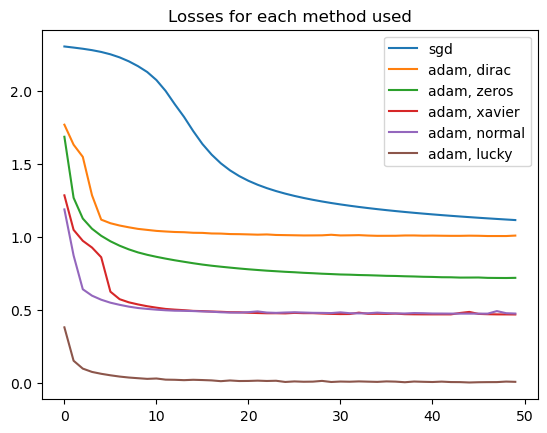

In [303]:
# Plot every loss with test loss as avg
fig, ax = plt.subplots() 

ax.plot(cnn_loss_sgd_1, label='sgd')
ax.plot(losses['cnn dirac'], label='adam, dirac')
ax.plot(losses['cnn zeros'], label='adam, zeros')
ax.plot(losses['xavier'], label='adam, xavier')
ax.plot(losses['cnn normal'], label='adam, normal')

ax.plot(fcnn_loss_adam, label='adam, lucky')

ax.set_title("Losses for each method used")

plt.legend()
plt.show()

Text(0.5, 1.0, 'Loss of SGD-trained CNN')

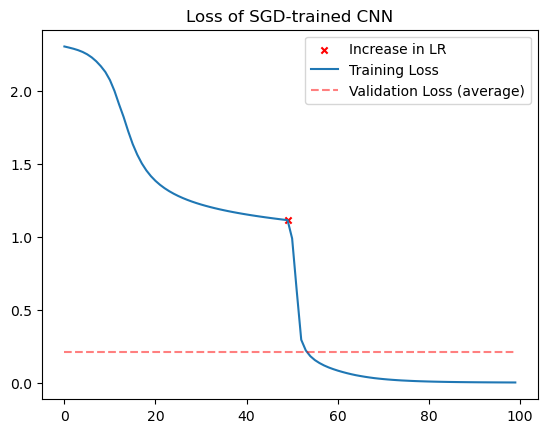

In [274]:
fig, ax = plt.subplots()

ax.scatter(49, cnn_loss_sgd_1[49], marker='x', color='red', label="Increase in LR", s = 20)
ax.plot(cnn_loss_sgd := np.concatenate([cnn_loss_sgd_1, cnn_loss_sgd_2]), label="Training Loss")
ax.plot([test_loss] * cnn_loss_sgd.shape[0], label="Validation Loss (average)", alpha=0.5, color="red", linestyle="--")

ax.legend()
ax.set_title("Loss of SGD-trained CNN")

In [290]:
np.savetxt("./losses/cnn_sgd.csv", cnn_loss_sgd)

EVALUATING MODEL


100%|██████████| 329/329 [00:04<00:00, 72.03it/s]


EVALUATING MODEL


100%|██████████| 141/141 [00:01<00:00, 75.76it/s]


EVALUATING MODEL


100%|██████████| 10000/10000 [00:25<00:00, 395.79it/s]


TESTING MODEL ON TRAIN DATA
MODEL F1-SCORE: 0.9989771562177727
MODEL PRECISION: 0.9989784510888977
MODEL RECALL: 0.9989762841248753

TESTING MODEL ON VALIDATION DATA
MODEL F1-SCORE: 0.9580543454987319
MODEL PRECISION: 0.9580827497075959
MODEL RECALL: 0.9580855189761746

TESTING MODEL ON TESTING DATA
MODEL F1-SCORE: 0.9034146922877924
MODEL PRECISION: 0.9041723940102957
MODEL RECALL: 0.9034000000000001



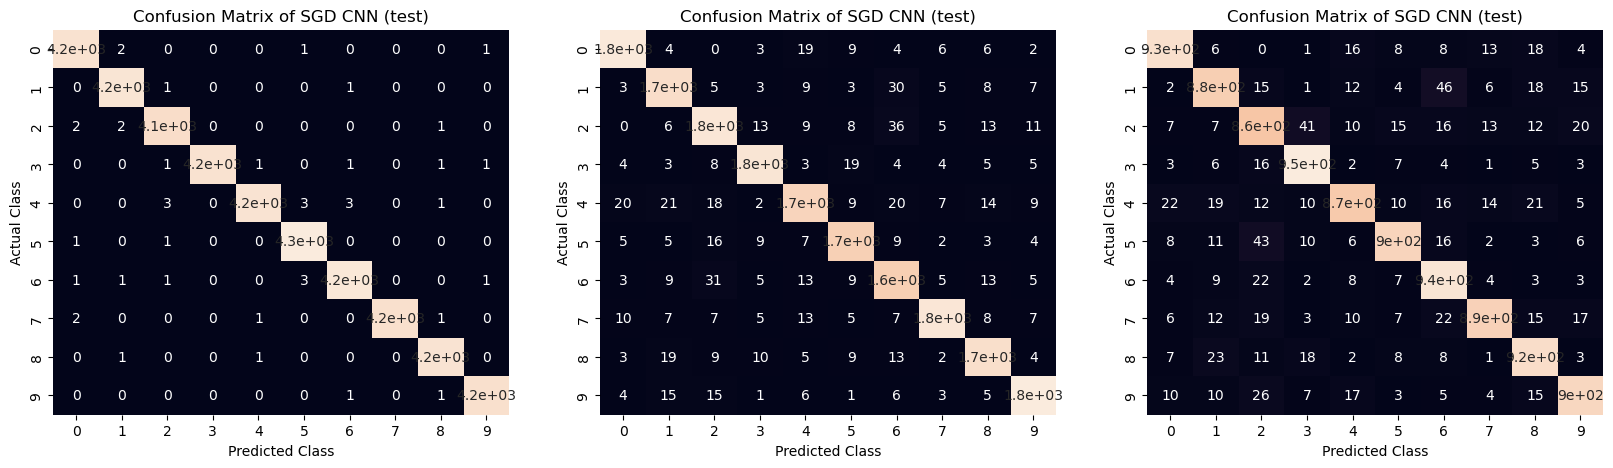

In [198]:
model_results(cnn_sgd, train_loader, val_loader, test_loader, data, "SGD CNN")

In [235]:
precisions = macro_precision(val_model(cnn_sgd, val_loader, data), get_avg=False)
recalls = macro_recall(val_model(cnn_sgd, val_loader, data), get_avg=False)
cats = data.targets.unique()

EVALUATING MODEL


100%|██████████| 141/141 [00:01<00:00, 72.59it/s]


EVALUATING MODEL


100%|██████████| 141/141 [00:02<00:00, 70.00it/s]


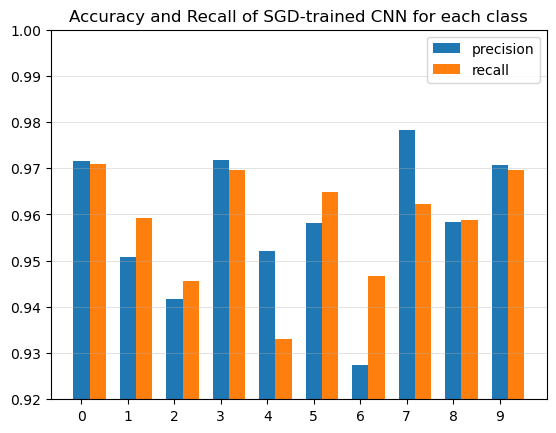

In [254]:
fig, ax = plt.subplots()

w = 0.35
ax.bar(cats, precisions, width=w, label='precision')
ax.bar(cats+w, recalls, width=w, label='recall')

ax.legend()

plt.grid(True, 'major', 'y', ls='-', lw=.5, alpha=.5)

ax.set_ylim(0.92, 1)
ax.set_xticks(cats)
ax.set_title("Accuracy and Recall of SGD-trained CNN for each class")

plt.show()

In [ ]:
# Conclusion: Overfit as on validation and testing the performance is significantly lower.
# For performance metric, precision is still OK as recall is more or less the same; infact F1-score is more or less the same

# Modelling Again: Try Dropout regularization

### FCNNN

In [91]:
fcnn_dropout = FCNN(regularize=True, regularize_param=0.5) 

In [92]:
fcnn_adam_dropout = torch.optim.Adam(fcnn_dropout.parameters(), lr=0.0005)
loss_dropout = train_model(fcnn_dropout, 50, train_loader, CE, fcnn_adam_dropout)

TRAINING MODEL!


0it [00:00, ?it/s]

329it [00:04, 67.37it/s]


Epoch: 1 | Loss: 1.3888 | Train Accuracy: 47.9897 | Time: 4.89


329it [00:05, 63.90it/s]


Epoch: 2 | Loss: 1.2704 | Train Accuracy: 51.7792 | Time: 5.15


329it [00:06, 51.60it/s]


Epoch: 3 | Loss: 1.2314 | Train Accuracy: 52.8392 | Time: 6.38


329it [00:06, 54.75it/s]


Epoch: 4 | Loss: 1.2256 | Train Accuracy: 53.1012 | Time: 6.01


329it [00:06, 53.18it/s]


Epoch: 5 | Loss: 1.2167 | Train Accuracy: 53.1917 | Time: 6.19


329it [00:05, 58.38it/s]


Epoch: 6 | Loss: 1.1993 | Train Accuracy: 53.6728 | Time: 5.64


329it [00:05, 56.01it/s]


Epoch: 7 | Loss: 1.1836 | Train Accuracy: 54.4279 | Time: 5.88


329it [00:09, 36.30it/s]


Epoch: 8 | Loss: 1.1877 | Train Accuracy: 54.0706 | Time: 9.07


329it [00:06, 48.28it/s]


Epoch: 9 | Loss: 1.1758 | Train Accuracy: 54.5446 | Time: 6.82


329it [00:06, 53.42it/s]


Epoch: 10 | Loss: 1.1906 | Train Accuracy: 53.8634 | Time: 6.16


329it [00:05, 56.31it/s]


Epoch: 11 | Loss: 1.1760 | Train Accuracy: 54.6280 | Time: 5.85


329it [00:05, 57.32it/s]


Epoch: 12 | Loss: 1.1786 | Train Accuracy: 54.3445 | Time: 5.74


329it [00:05, 57.99it/s]


Epoch: 13 | Loss: 1.1632 | Train Accuracy: 54.8923 | Time: 5.68


329it [00:05, 56.33it/s]


Epoch: 14 | Loss: 1.1698 | Train Accuracy: 54.8852 | Time: 5.84


329it [00:06, 50.16it/s]


Epoch: 15 | Loss: 1.1769 | Train Accuracy: 54.4827 | Time: 6.56


329it [00:06, 53.20it/s]


Epoch: 16 | Loss: 1.1822 | Train Accuracy: 54.3921 | Time: 6.19


329it [00:06, 47.74it/s]


Epoch: 17 | Loss: 1.1741 | Train Accuracy: 54.6422 | Time: 6.89


329it [00:06, 53.93it/s]


Epoch: 18 | Loss: 1.1818 | Train Accuracy: 54.3874 | Time: 6.11


329it [00:05, 56.19it/s]


Epoch: 19 | Loss: 1.1637 | Train Accuracy: 54.9948 | Time: 5.86


329it [00:06, 52.12it/s]


Epoch: 20 | Loss: 1.1590 | Train Accuracy: 55.2020 | Time: 6.32


329it [00:07, 43.38it/s]


Epoch: 21 | Loss: 1.1703 | Train Accuracy: 54.6113 | Time: 7.59


329it [00:06, 48.14it/s]


Epoch: 22 | Loss: 1.1662 | Train Accuracy: 54.9829 | Time: 6.84


329it [00:06, 51.70it/s]


Epoch: 23 | Loss: 1.1669 | Train Accuracy: 54.9662 | Time: 6.37


329it [00:06, 48.66it/s]


Epoch: 24 | Loss: 1.1590 | Train Accuracy: 55.2306 | Time: 6.77


329it [00:08, 41.10it/s]


Epoch: 25 | Loss: 1.1525 | Train Accuracy: 55.3711 | Time: 8.01


329it [00:05, 56.88it/s]


Epoch: 26 | Loss: 1.1709 | Train Accuracy: 54.6232 | Time: 5.79


329it [00:07, 46.08it/s]


Epoch: 27 | Loss: 1.1719 | Train Accuracy: 54.6613 | Time: 7.14


329it [00:07, 46.88it/s]


Epoch: 28 | Loss: 1.1679 | Train Accuracy: 54.8900 | Time: 7.02


329it [00:06, 52.45it/s]


Epoch: 29 | Loss: 1.1651 | Train Accuracy: 54.8518 | Time: 6.28


329it [00:06, 49.11it/s]


Epoch: 30 | Loss: 1.1639 | Train Accuracy: 54.8709 | Time: 6.70


329it [00:07, 42.50it/s]


Epoch: 31 | Loss: 1.1563 | Train Accuracy: 55.3235 | Time: 7.75


329it [00:07, 43.53it/s]


Epoch: 32 | Loss: 1.1606 | Train Accuracy: 55.2115 | Time: 7.57


329it [00:06, 52.03it/s]


Epoch: 33 | Loss: 1.1531 | Train Accuracy: 55.2568 | Time: 6.33


329it [00:10, 30.03it/s]


Epoch: 34 | Loss: 1.1641 | Train Accuracy: 54.8661 | Time: 10.96


329it [00:05, 57.08it/s]


Epoch: 35 | Loss: 1.1642 | Train Accuracy: 54.7018 | Time: 5.77


329it [00:05, 59.28it/s]


Epoch: 36 | Loss: 1.1516 | Train Accuracy: 55.3949 | Time: 5.55


329it [00:05, 56.84it/s]


Epoch: 37 | Loss: 1.1605 | Train Accuracy: 55.2615 | Time: 5.79


329it [00:11, 29.24it/s]


Epoch: 38 | Loss: 1.1562 | Train Accuracy: 55.3282 | Time: 11.26


329it [00:22, 14.48it/s]


Epoch: 39 | Loss: 1.1547 | Train Accuracy: 55.3473 | Time: 22.74


329it [00:23, 13.94it/s]


Epoch: 40 | Loss: 1.1682 | Train Accuracy: 54.7566 | Time: 23.60


329it [00:22, 14.31it/s]


Epoch: 41 | Loss: 1.1637 | Train Accuracy: 54.9852 | Time: 23.00


329it [00:24, 13.62it/s]


Epoch: 42 | Loss: 1.1605 | Train Accuracy: 55.0948 | Time: 24.17


329it [00:22, 14.78it/s]


Epoch: 43 | Loss: 1.1621 | Train Accuracy: 55.1043 | Time: 22.27


329it [00:22, 14.80it/s]


Epoch: 44 | Loss: 1.1709 | Train Accuracy: 54.6708 | Time: 22.23


329it [00:14, 23.22it/s]


Epoch: 45 | Loss: 1.1590 | Train Accuracy: 55.2377 | Time: 14.17


329it [00:14, 22.04it/s]


Epoch: 46 | Loss: 1.1618 | Train Accuracy: 55.0138 | Time: 14.93


329it [00:13, 24.22it/s]


Epoch: 47 | Loss: 1.1605 | Train Accuracy: 54.9876 | Time: 13.59


329it [00:09, 33.10it/s]


Epoch: 48 | Loss: 1.1564 | Train Accuracy: 55.1829 | Time: 9.95


329it [00:05, 61.96it/s]


Epoch: 49 | Loss: 1.1687 | Train Accuracy: 54.8399 | Time: 5.31


329it [00:14, 22.05it/s]

Epoch: 50 | Loss: 1.1599 | Train Accuracy: 55.1258 | Time: 14.93


EVALUATING MODEL


100%|██████████| 329/329 [00:05<00:00, 57.44it/s]


EVALUATING MODEL


100%|██████████| 141/141 [00:02<00:00, 56.78it/s]


EVALUATING MODEL


100%|██████████| 10000/10000 [01:02<00:00, 158.93it/s]


TESTING MODEL ON TRAIN DATA
MODEL F1-SCORE: 0.9984045573896392
MODEL PRECISION: 0.9984139940467562
MODEL RECALL: 0.9983992845965325

TESTING MODEL ON VALIDATION DATA
MODEL F1-SCORE: 0.9619929316723101
MODEL PRECISION: 0.9622778218446832
MODEL RECALL: 0.9620313598733594

TESTING MODEL ON TESTING DATA
MODEL F1-SCORE: 0.9113858759250275
MODEL PRECISION: 0.9135581797997119
MODEL RECALL: 0.9112



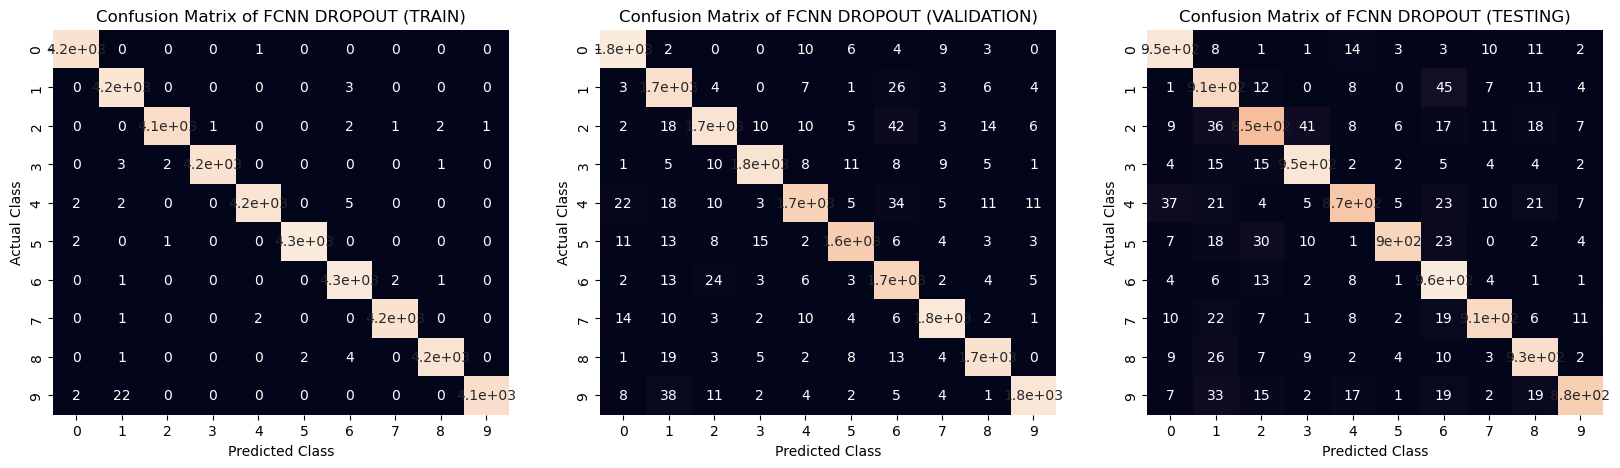

In [ ]:
model_results(fcnn_dropout, train_loader, val_loader, test_loader, data, 'FCNN DROPOUT')

EVALUATING MODEL


100%|██████████| 329/329 [00:05<00:00, 58.54it/s]


EVALUATING MODEL


100%|██████████| 141/141 [00:02<00:00, 57.65it/s]


EVALUATING MODEL


100%|██████████| 10000/10000 [00:46<00:00, 214.39it/s]


TESTING MODEL ON TRAIN DATA
MODEL F1-SCORE: 0.9986889278217111
MODEL PRECISION: 0.9986948026143594
MODEL RECALL: 0.9986859876580192

TESTING MODEL ON VALIDATION DATA
MODEL F1-SCORE: 0.964296563850227
MODEL PRECISION: 0.9644549994730639
MODEL RECALL: 0.9643764953642735

TESTING MODEL ON TESTING DATA
MODEL F1-SCORE: 0.9081947418831765
MODEL PRECISION: 0.9098350224784483
MODEL RECALL: 0.9081999999999999



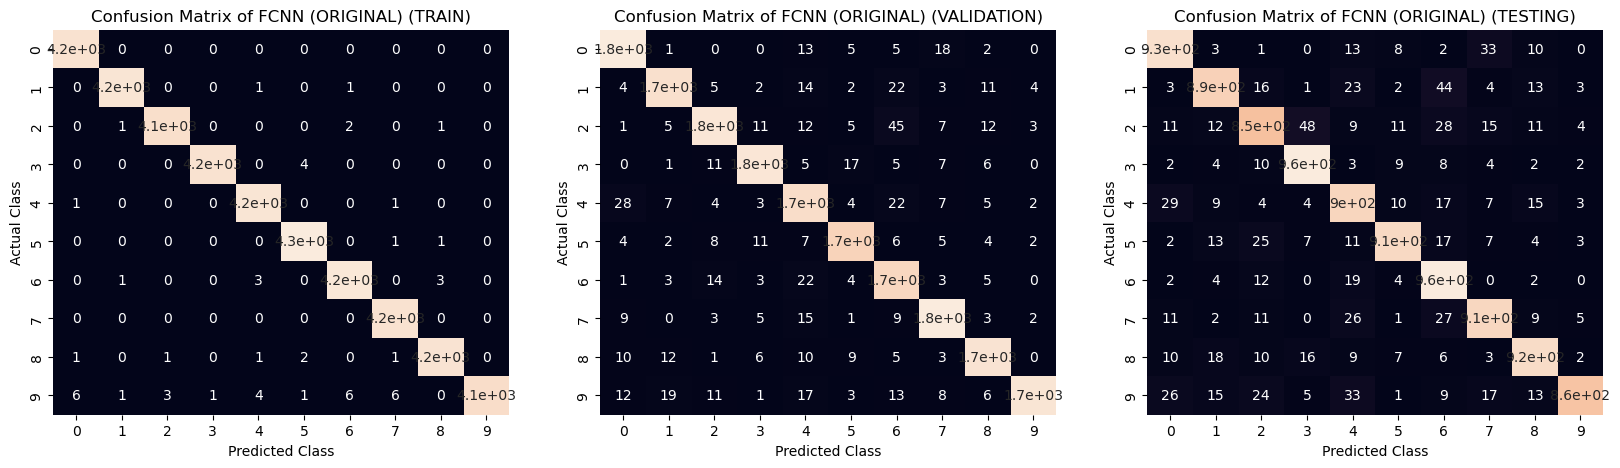

In [283]:
model_results(first_fcnn, train_loader, val_loader, test_loader, data, 'FCNN (ORIGINAL)')

### CNN

In [110]:
cnn_dropout = CNN(regularize=True, regularize_param=0.25)
cnn_sgd_dropout = torch.optim.SGD(cnn_dropout.parameters(), lr=0.01)
loss_dropout_cnn = train_model(cnn_dropout, 50, train_loader, CE, cnn_sgd_dropout)

TRAINING MODEL!


329it [00:05, 56.21it/s]


Epoch: 1 | Loss: 2.2762 | Train Accuracy: 24.7213 | Time: 5.86


329it [00:05, 55.50it/s]


Epoch: 2 | Loss: 1.6998 | Train Accuracy: 53.7181 | Time: 5.93


329it [00:05, 57.35it/s]


Epoch: 3 | Loss: 0.9689 | Train Accuracy: 71.3034 | Time: 5.74


329it [00:05, 57.22it/s]


Epoch: 4 | Loss: 0.7354 | Train Accuracy: 77.5033 | Time: 5.75


329it [00:05, 56.06it/s]


Epoch: 5 | Loss: 0.6525 | Train Accuracy: 80.1496 | Time: 5.87


329it [00:10, 32.43it/s]


Epoch: 6 | Loss: 0.5911 | Train Accuracy: 81.9741 | Time: 10.15


329it [00:05, 59.78it/s]


Epoch: 7 | Loss: 0.5430 | Train Accuracy: 83.3484 | Time: 5.50


329it [00:05, 59.59it/s]


Epoch: 8 | Loss: 0.5012 | Train Accuracy: 84.7704 | Time: 5.52


329it [00:05, 58.33it/s]


Epoch: 9 | Loss: 0.4685 | Train Accuracy: 85.8232 | Time: 5.64


329it [00:05, 58.06it/s]


Epoch: 10 | Loss: 0.4408 | Train Accuracy: 86.3781 | Time: 5.67


329it [00:05, 56.48it/s]


Epoch: 11 | Loss: 0.4170 | Train Accuracy: 87.1975 | Time: 5.83


329it [00:05, 57.12it/s]


Epoch: 12 | Loss: 0.3976 | Train Accuracy: 87.9121 | Time: 5.76


329it [00:05, 57.82it/s]


Epoch: 13 | Loss: 0.3763 | Train Accuracy: 88.5456 | Time: 5.69


329it [00:05, 58.21it/s]


Epoch: 14 | Loss: 0.3651 | Train Accuracy: 89.0053 | Time: 5.65


329it [00:05, 57.61it/s]


Epoch: 15 | Loss: 0.3457 | Train Accuracy: 89.4436 | Time: 5.71


329it [00:05, 57.53it/s]


Epoch: 16 | Loss: 0.3339 | Train Accuracy: 89.9319 | Time: 5.72


329it [00:05, 57.57it/s]


Epoch: 17 | Loss: 0.3257 | Train Accuracy: 90.2177 | Time: 5.72


329it [00:05, 56.89it/s]


Epoch: 18 | Loss: 0.3152 | Train Accuracy: 90.5273 | Time: 5.79


329it [00:05, 58.95it/s]


Epoch: 19 | Loss: 0.3023 | Train Accuracy: 91.0156 | Time: 5.58


329it [00:05, 57.65it/s]


Epoch: 20 | Loss: 0.2933 | Train Accuracy: 91.2252 | Time: 5.71


329it [00:05, 58.50it/s]


Epoch: 21 | Loss: 0.2829 | Train Accuracy: 91.5349 | Time: 5.63


329it [00:05, 58.58it/s]


Epoch: 22 | Loss: 0.2749 | Train Accuracy: 91.8826 | Time: 5.62


329it [00:05, 58.66it/s]


Epoch: 23 | Loss: 0.2676 | Train Accuracy: 92.1351 | Time: 5.61


329it [00:05, 57.95it/s]


Epoch: 24 | Loss: 0.2637 | Train Accuracy: 92.0446 | Time: 5.68


329it [00:05, 56.47it/s]


Epoch: 25 | Loss: 0.2581 | Train Accuracy: 92.2709 | Time: 5.83


329it [00:05, 59.19it/s]


Epoch: 26 | Loss: 0.2521 | Train Accuracy: 92.5781 | Time: 5.56


329it [00:05, 59.22it/s]


Epoch: 27 | Loss: 0.2464 | Train Accuracy: 92.7282 | Time: 5.56


329it [00:05, 56.90it/s]


Epoch: 28 | Loss: 0.2408 | Train Accuracy: 92.8759 | Time: 5.79


329it [00:05, 59.45it/s]


Epoch: 29 | Loss: 0.2335 | Train Accuracy: 93.1522 | Time: 5.54


329it [00:05, 57.80it/s]


Epoch: 30 | Loss: 0.2314 | Train Accuracy: 93.1641 | Time: 5.70


329it [00:05, 59.36it/s]


Epoch: 31 | Loss: 0.2273 | Train Accuracy: 93.3784 | Time: 5.55


329it [00:05, 58.56it/s]


Epoch: 32 | Loss: 0.2224 | Train Accuracy: 93.4475 | Time: 5.62


329it [00:05, 58.35it/s]


Epoch: 33 | Loss: 0.2181 | Train Accuracy: 93.5809 | Time: 5.64


329it [00:05, 57.94it/s]


Epoch: 34 | Loss: 0.2182 | Train Accuracy: 93.6047 | Time: 5.68


329it [00:05, 58.78it/s]


Epoch: 35 | Loss: 0.2112 | Train Accuracy: 93.7500 | Time: 5.60


329it [00:05, 59.87it/s]


Epoch: 36 | Loss: 0.2093 | Train Accuracy: 93.8548 | Time: 5.50


329it [00:05, 57.06it/s]


Epoch: 37 | Loss: 0.2024 | Train Accuracy: 94.0072 | Time: 5.77


329it [00:05, 57.29it/s]


Epoch: 38 | Loss: 0.1991 | Train Accuracy: 94.0954 | Time: 5.75


329it [00:10, 32.57it/s]


Epoch: 39 | Loss: 0.1973 | Train Accuracy: 94.1073 | Time: 10.11


329it [00:10, 31.45it/s]


Epoch: 40 | Loss: 0.1953 | Train Accuracy: 94.2716 | Time: 10.47


329it [00:05, 58.39it/s]


Epoch: 41 | Loss: 0.1916 | Train Accuracy: 94.4550 | Time: 5.64


329it [00:05, 57.22it/s]


Epoch: 42 | Loss: 0.1899 | Train Accuracy: 94.3860 | Time: 5.75


329it [00:11, 27.77it/s]


Epoch: 43 | Loss: 0.1894 | Train Accuracy: 94.3502 | Time: 11.85


329it [00:16, 20.43it/s]


Epoch: 44 | Loss: 0.1842 | Train Accuracy: 94.5979 | Time: 16.12


329it [00:14, 22.26it/s]


Epoch: 45 | Loss: 0.1843 | Train Accuracy: 94.6241 | Time: 14.79


329it [00:05, 60.35it/s]


Epoch: 46 | Loss: 0.1810 | Train Accuracy: 94.7266 | Time: 5.45


329it [00:05, 57.18it/s]


Epoch: 47 | Loss: 0.1744 | Train Accuracy: 94.8671 | Time: 5.76


329it [00:05, 55.85it/s]


Epoch: 48 | Loss: 0.1737 | Train Accuracy: 94.8290 | Time: 5.89


329it [00:05, 57.40it/s]


Epoch: 49 | Loss: 0.1709 | Train Accuracy: 94.9933 | Time: 5.73


329it [00:05, 57.64it/s]

Epoch: 50 | Loss: 0.1690 | Train Accuracy: 94.9909 | Time: 5.71


EVALUATING MODEL


100%|██████████| 329/329 [00:04<00:00, 71.60it/s]


EVALUATING MODEL


100%|██████████| 141/141 [00:01<00:00, 74.12it/s]


EVALUATING MODEL


100%|██████████| 10000/10000 [00:50<00:00, 196.86it/s]


TESTING MODEL ON TRAIN DATA
MODEL F1-SCORE: 0.9681093408346844
MODEL PRECISION: 0.9691897561360617
MODEL RECALL: 0.9678428926280326

TESTING MODEL ON VALIDATION DATA
MODEL F1-SCORE: 0.9501086032397538
MODEL PRECISION: 0.951227973641724
MODEL RECALL: 0.9500784919610226

TESTING MODEL ON TESTING DATA
MODEL F1-SCORE: 0.8852336562386801
MODEL PRECISION: 0.8900296593701492
MODEL RECALL: 0.8849



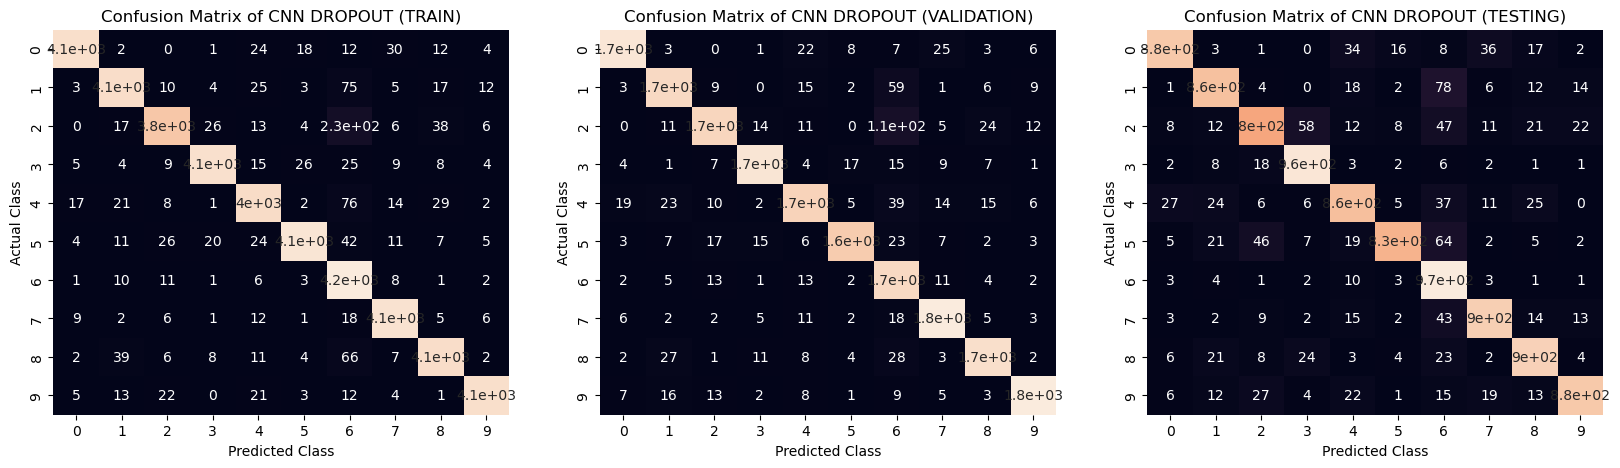

In [282]:
model_results(cnn_dropout, train_loader, val_loader, test_loader, data, 'CNN DROPOUT')

EVALUATING MODEL


100%|██████████| 329/329 [00:04<00:00, 75.29it/s]


EVALUATING MODEL


100%|██████████| 141/141 [00:01<00:00, 75.03it/s]


EVALUATING MODEL


100%|██████████| 10000/10000 [00:26<00:00, 382.81it/s]


TESTING MODEL ON TRAIN DATA
MODEL F1-SCORE: 0.9989771562177727
MODEL PRECISION: 0.9989784510888977
MODEL RECALL: 0.9989762841248753

TESTING MODEL ON VALIDATION DATA
MODEL F1-SCORE: 0.9580543454987319
MODEL PRECISION: 0.9580827497075959
MODEL RECALL: 0.9580855189761746

TESTING MODEL ON TESTING DATA
MODEL F1-SCORE: 0.9034146922877924
MODEL PRECISION: 0.9041723940102957
MODEL RECALL: 0.9034000000000001



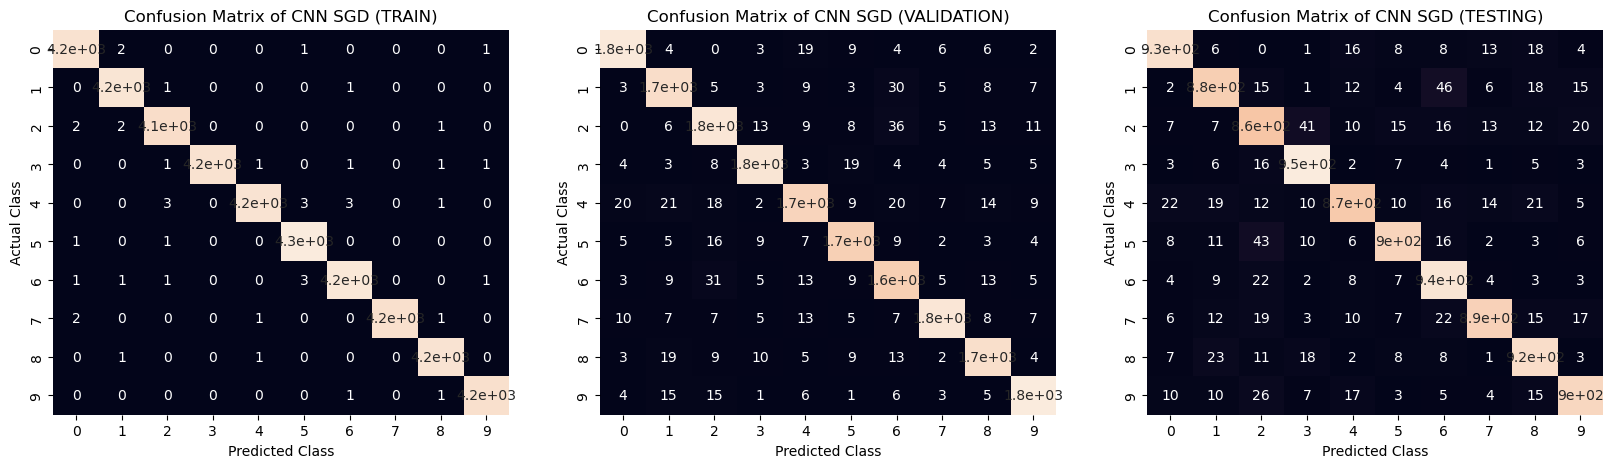

In [284]:
model_results(cnn_sgd, train_loader, val_loader, test_loader, data, 'CNN SGD')

## Fine Tuning Best Model with Large Dropout (p=0.8)
Insipired by https://arxiv.org/pdf/2403.00946

### CNN

In [285]:
# load incase we do not have my_cnn (see model training)
my_cnn = CNN()

my_cnn.load_state_dict(torch.load('./weights/cnn_super'))

<All keys matched successfully>

In [148]:
cnn_dropout_finetuning = CNN(regularize=True, regularize_param = 0.8, fine_tuning=True)

cnn_dropout_finetuning.load_state_dict(my_cnn.state_dict())


<All keys matched successfully>

In [149]:
cnn_sgd_dropout_finetuning = torch.optim.SGD(cnn_dropout_finetuning.parameters(), 0.05)
loss_dropout_cnn_finetuning = train_model(cnn_dropout_finetuning, 25, train_loader, CE, cnn_sgd_dropout_finetuning)

TRAINING MODEL!


329it [00:06, 54.54it/s]


Epoch: 1 | Loss: 0.9705 | Train Accuracy: 70.4792 | Time: 6.04


329it [00:05, 55.85it/s]


Epoch: 2 | Loss: 0.6440 | Train Accuracy: 78.7276 | Time: 5.89


329it [00:05, 56.06it/s]


Epoch: 3 | Loss: 0.5852 | Train Accuracy: 80.6736 | Time: 5.87


329it [00:05, 55.18it/s]


Epoch: 4 | Loss: 0.5462 | Train Accuracy: 81.9217 | Time: 5.96


329it [00:05, 55.98it/s]


Epoch: 5 | Loss: 0.5161 | Train Accuracy: 83.1388 | Time: 5.88


329it [00:05, 57.12it/s]


Epoch: 6 | Loss: 0.4971 | Train Accuracy: 83.8653 | Time: 5.77


329it [00:05, 57.17it/s]


Epoch: 7 | Loss: 0.4741 | Train Accuracy: 84.5465 | Time: 5.76


329it [00:05, 56.20it/s]


Epoch: 8 | Loss: 0.4694 | Train Accuracy: 84.6799 | Time: 5.86


329it [00:05, 58.30it/s]


Epoch: 9 | Loss: 0.4604 | Train Accuracy: 84.9204 | Time: 5.65


329it [00:05, 58.12it/s]


Epoch: 10 | Loss: 0.4423 | Train Accuracy: 85.4849 | Time: 5.66


329it [00:05, 58.71it/s]


Epoch: 11 | Loss: 0.4339 | Train Accuracy: 85.6731 | Time: 5.61


329it [00:05, 58.12it/s]


Epoch: 12 | Loss: 0.4325 | Train Accuracy: 86.0828 | Time: 5.66


329it [00:05, 56.98it/s]


Epoch: 13 | Loss: 0.4287 | Train Accuracy: 86.1400 | Time: 5.78


329it [00:05, 55.75it/s]


Epoch: 14 | Loss: 0.4116 | Train Accuracy: 86.7664 | Time: 5.90


329it [00:05, 57.03it/s]


Epoch: 15 | Loss: 0.4145 | Train Accuracy: 86.6401 | Time: 5.77


329it [00:05, 57.24it/s]


Epoch: 16 | Loss: 0.4016 | Train Accuracy: 86.9903 | Time: 5.75


329it [00:05, 58.43it/s]


Epoch: 17 | Loss: 0.4000 | Train Accuracy: 87.1403 | Time: 5.63


329it [00:05, 59.04it/s]


Epoch: 18 | Loss: 0.3889 | Train Accuracy: 87.4071 | Time: 5.58


329it [00:05, 57.08it/s]


Epoch: 19 | Loss: 0.3862 | Train Accuracy: 87.6596 | Time: 5.77


329it [00:05, 56.96it/s]


Epoch: 20 | Loss: 0.3844 | Train Accuracy: 87.5643 | Time: 5.78


329it [00:05, 57.27it/s]


Epoch: 21 | Loss: 0.3686 | Train Accuracy: 88.2146 | Time: 5.75


329it [00:05, 55.94it/s]


Epoch: 22 | Loss: 0.3760 | Train Accuracy: 87.8406 | Time: 5.89


329it [00:06, 54.18it/s]


Epoch: 23 | Loss: 0.3619 | Train Accuracy: 88.2622 | Time: 6.08


329it [00:06, 53.45it/s]


Epoch: 24 | Loss: 0.3656 | Train Accuracy: 88.2503 | Time: 6.16


329it [00:06, 54.68it/s]

Epoch: 25 | Loss: 0.3577 | Train Accuracy: 88.6219 | Time: 6.02


EVALUATING MODEL


100%|██████████| 329/329 [00:04<00:00, 74.26it/s]


EVALUATING MODEL


100%|██████████| 141/141 [00:01<00:00, 75.19it/s]


EVALUATING MODEL


100%|██████████| 10000/10000 [00:26<00:00, 375.14it/s]


TESTING MODEL ON TRAIN DATA
MODEL F1-SCORE: 0.9757092134820915
MODEL PRECISION: 0.9759004126588161
MODEL RECALL: 0.9756442524906836

TESTING MODEL ON VALIDATION DATA
MODEL F1-SCORE: 0.9513932529544491
MODEL PRECISION: 0.9516051370132118
MODEL RECALL: 0.9514780180989636

TESTING MODEL ON TESTING DATA
MODEL F1-SCORE: 0.8810299037449261
MODEL PRECISION: 0.8848530088506148
MODEL RECALL: 0.8808999999999999



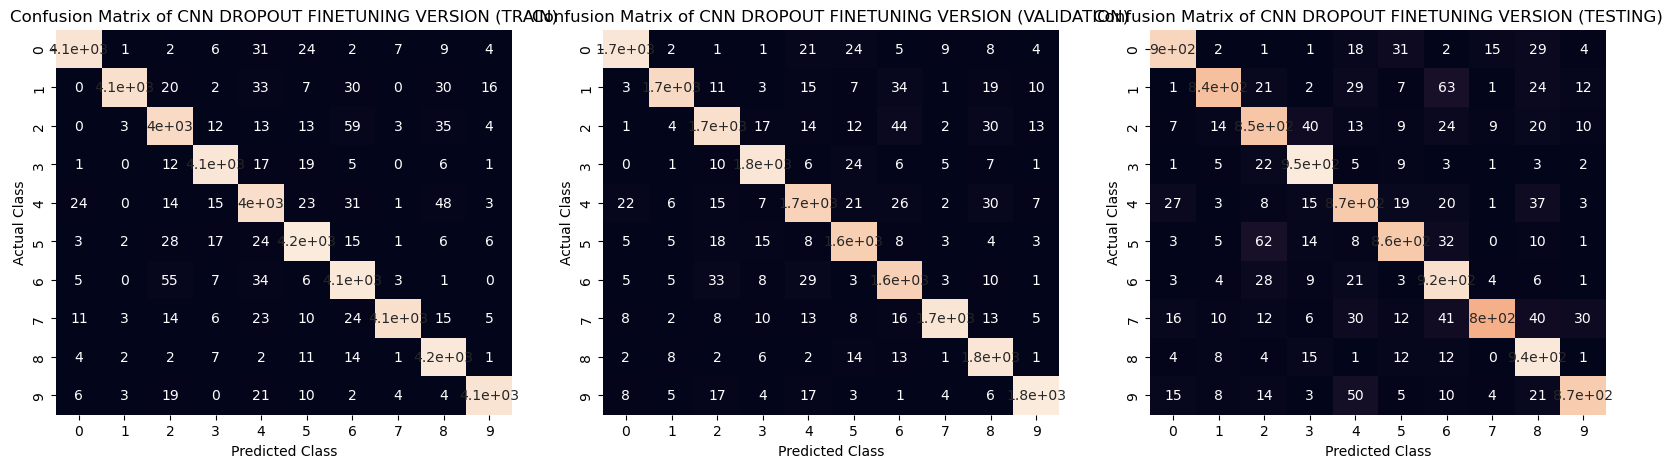

In [286]:
model_results(cnn_dropout_finetuning, train_loader, val_loader, test_loader, data, 'CNN DROPOUT FINETUNING VERSION')

EVALUATING MODEL


100%|██████████| 329/329 [00:04<00:00, 74.57it/s]


EVALUATING MODEL


100%|██████████| 141/141 [00:01<00:00, 75.54it/s]


EVALUATING MODEL


100%|██████████| 10000/10000 [00:37<00:00, 264.24it/s]


TESTING MODEL ON TRAIN DATA
MODEL F1-SCORE: 0.9991651086582436
MODEL PRECISION: 0.9991683855393184
MODEL RECALL: 0.9991650723613287

TESTING MODEL ON VALIDATION DATA
MODEL F1-SCORE: 0.9684301450885362
MODEL PRECISION: 0.9684405481873858
MODEL RECALL: 0.9684440795491721

TESTING MODEL ON TESTING DATA
MODEL F1-SCORE: 0.9195026457354716
MODEL PRECISION: 0.920212339017813
MODEL RECALL: 0.9196



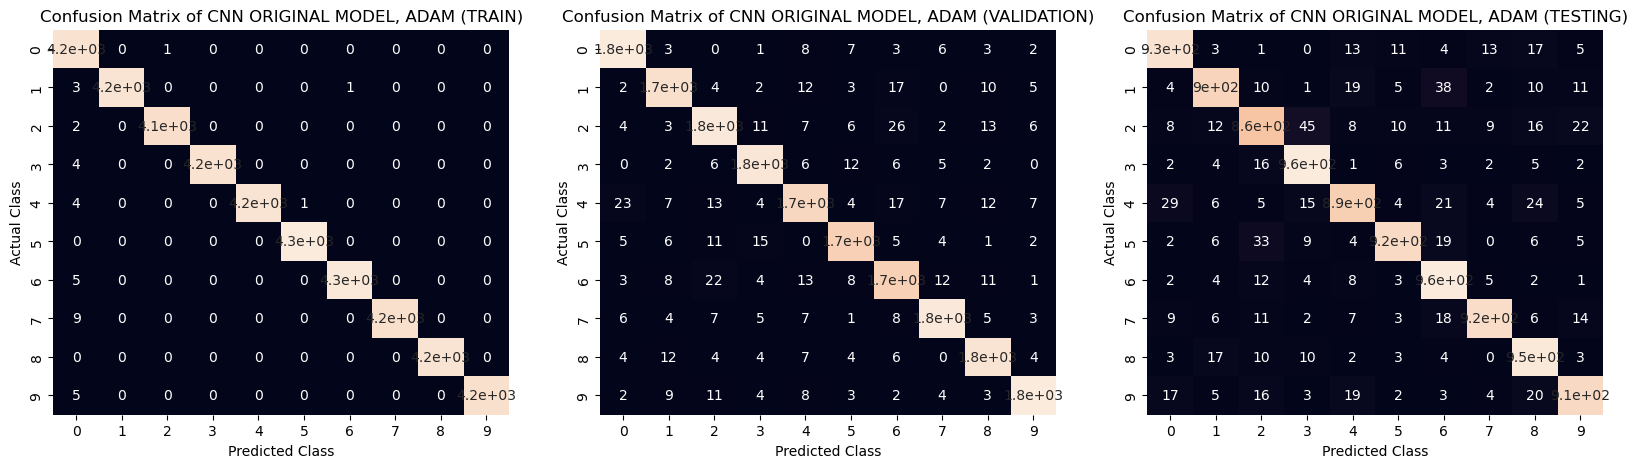

In [287]:
model_results(my_cnn, train_loader, val_loader, test_loader, data, 'CNN ORIGINAL MODEL, ADAM')

### FCNN

In [187]:
fcnn_dropout_finetuning = FCNN(regularize = True,
                               regularize_param = 0.8,
                               fine_tuning = True)

fcnn_dropout_finetuning.load_state_dict(first_fcnn.state_dict())

<All keys matched successfully>

In [188]:
fcnn_sgd_dropout_finetuning = torch.optim.SGD(fcnn_dropout_finetuning.parameters(), 0.05)
loss_dropout_fcnn_finetuning = train_model(fcnn_dropout_finetuning, 15, train_loader, CE, fcnn_sgd_dropout_finetuning)

TRAINING MODEL!


0it [00:00, ?it/s]

329it [00:05, 65.53it/s]


Epoch: 1 | Loss: 0.0031 | Train Accuracy: 100.2072 | Time: 5.02


329it [00:05, 64.46it/s]


Epoch: 2 | Loss: 0.0018 | Train Accuracy: 100.2501 | Time: 5.11


329it [00:05, 61.24it/s]


Epoch: 3 | Loss: 0.0010 | Train Accuracy: 100.2620 | Time: 5.38


329it [00:04, 67.63it/s]


Epoch: 4 | Loss: 0.0007 | Train Accuracy: 100.2787 | Time: 4.87


329it [00:05, 57.86it/s]


Epoch: 5 | Loss: 0.0004 | Train Accuracy: 100.2882 | Time: 5.69


329it [00:04, 73.15it/s]


Epoch: 6 | Loss: 0.0006 | Train Accuracy: 100.2763 | Time: 4.50


329it [00:05, 60.87it/s]


Epoch: 7 | Loss: 0.0005 | Train Accuracy: 100.2858 | Time: 5.41


329it [00:05, 59.71it/s]


Epoch: 8 | Loss: 0.0002 | Train Accuracy: 100.3001 | Time: 5.51


329it [00:04, 68.65it/s]


Epoch: 9 | Loss: 0.0004 | Train Accuracy: 100.2930 | Time: 4.80


329it [00:05, 55.54it/s]


Epoch: 10 | Loss: 0.0004 | Train Accuracy: 100.2906 | Time: 5.93


329it [00:04, 73.01it/s]


Epoch: 11 | Loss: 0.0002 | Train Accuracy: 100.3025 | Time: 4.51


329it [00:05, 61.77it/s]


Epoch: 12 | Loss: 0.0002 | Train Accuracy: 100.2977 | Time: 5.33


329it [00:04, 68.03it/s]


Epoch: 13 | Loss: 0.0004 | Train Accuracy: 100.2930 | Time: 4.84


329it [00:05, 64.80it/s]


Epoch: 14 | Loss: 0.0003 | Train Accuracy: 100.2930 | Time: 5.08


329it [00:05, 62.58it/s]

Epoch: 15 | Loss: 0.0003 | Train Accuracy: 100.2930 | Time: 5.26


EVALUATING MODEL


100%|██████████| 329/329 [00:05<00:00, 57.60it/s]


EVALUATING MODEL


100%|██████████| 141/141 [00:02<00:00, 57.51it/s]


EVALUATING MODEL


100%|██████████| 10000/10000 [00:29<00:00, 333.95it/s]


TESTING MODEL ON TRAIN DATA
MODEL F1-SCORE: 1.0
MODEL PRECISION: 1.0
MODEL RECALL: 1.0

TESTING MODEL ON VALIDATION DATA
MODEL F1-SCORE: 0.9686287067575275
MODEL PRECISION: 0.9686378419100027
MODEL RECALL: 0.9686819620518026

TESTING MODEL ON TESTING DATA
MODEL F1-SCORE: 0.9167400422005016
MODEL PRECISION: 0.9173720156355817
MODEL RECALL: 0.9168



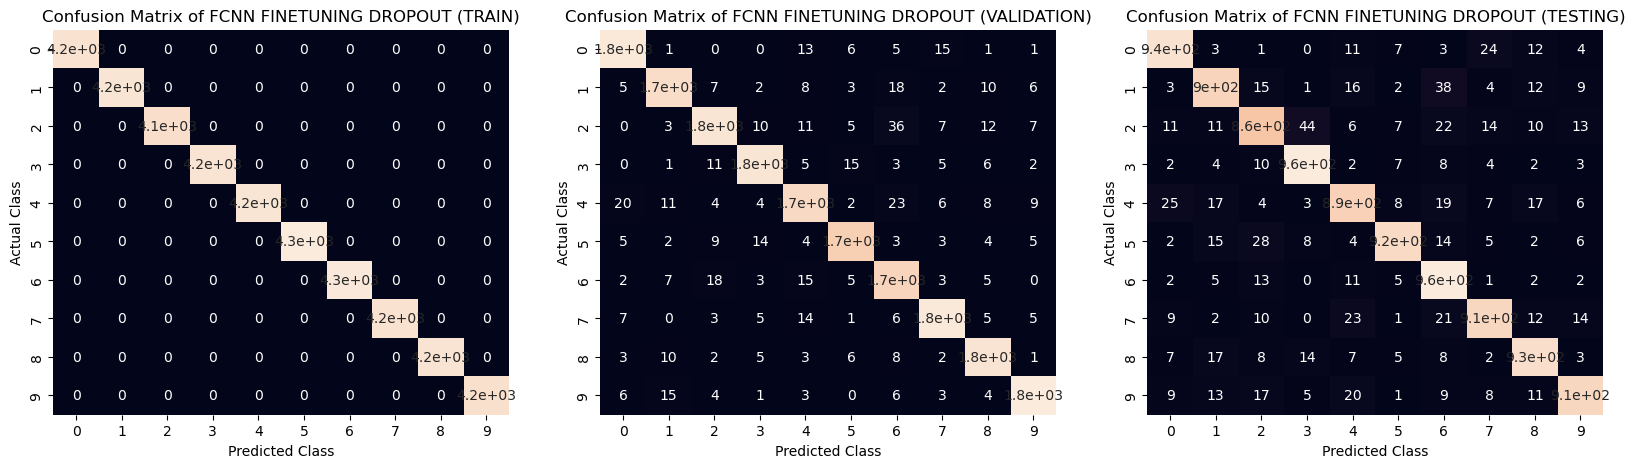

In [288]:
model_results(fcnn_dropout_finetuning, train_loader, val_loader, test_loader, data, 'FCNN FINETUNING DROPOUT')

EVALUATING MODEL


100%|██████████| 329/329 [00:05<00:00, 58.09it/s]


EVALUATING MODEL


100%|██████████| 141/141 [00:02<00:00, 56.89it/s]


EVALUATING MODEL


100%|██████████| 10000/10000 [00:31<00:00, 321.56it/s]


TESTING MODEL ON TRAIN DATA
MODEL F1-SCORE: 0.9986889278217111
MODEL PRECISION: 0.9986948026143594
MODEL RECALL: 0.9986859876580192

TESTING MODEL ON VALIDATION DATA
MODEL F1-SCORE: 0.964296563850227
MODEL PRECISION: 0.9644549994730639
MODEL RECALL: 0.9643764953642735

TESTING MODEL ON TESTING DATA
MODEL F1-SCORE: 0.9081947418831765
MODEL PRECISION: 0.9098350224784483
MODEL RECALL: 0.9081999999999999



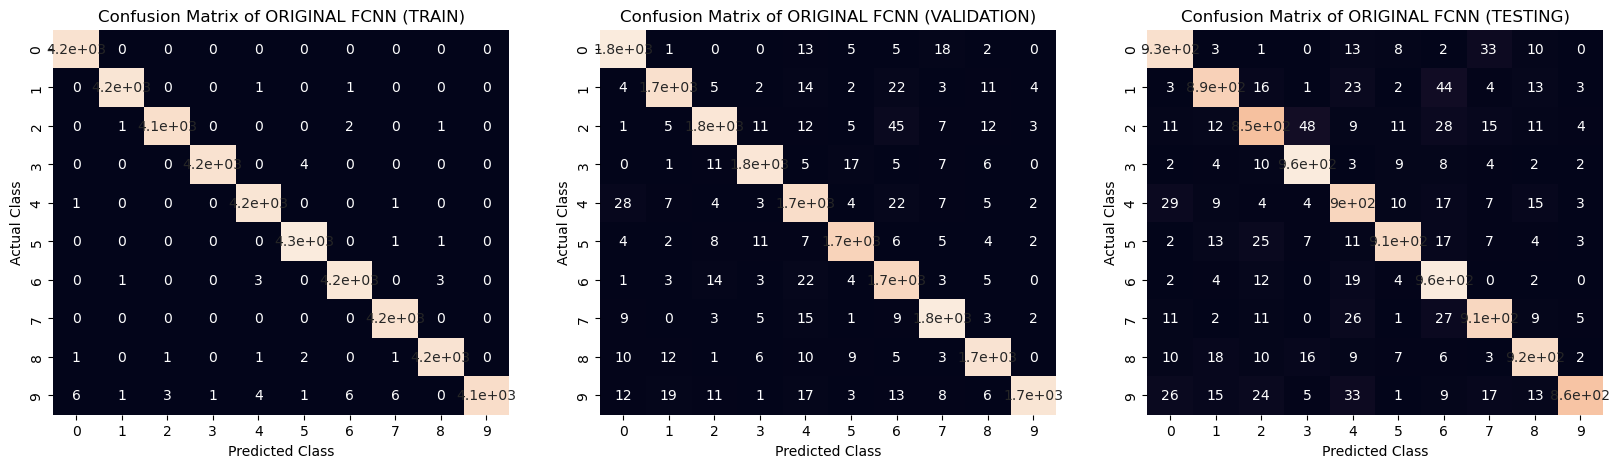

In [289]:
model_results(first_fcnn, train_loader, val_loader, test_loader, data, 'ORIGINAL FCNN')